In [1]:
import numpy as np
import pandas as pd

from datetime import datetime as dt
from datetime import date
import time

from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns

# 전처리 함수

In [2]:
## date : string to timestamp
def str_date2timestamp(df):
    date_lst = pd.to_datetime(df['date'])
    df['date'] = date_lst
    # return df

## -1~1이 아닌 값 수정 - Category intensity
def catScore_crop(df):
    for column in df.columns[-8:]:
        df.loc[df[column] < 0, column] = 0

    for column in df.columns[-8:]:
       for i in range(len(df)):
           if df[column][i] < 0:
                print('need to fix')
                return

## 점수 범위 조정
def make_avg_column(df_ym, df_score):
    new_df = pd.concat([df_ym[['date','year','month']], df_score],axis = 1)
    
    new_df['avgNV'] = new_df['NVscore'] / (new_df['PVnum'] + new_df['NVnum']) * (-1)
    new_df['avgPV'] = new_df['PVscore'] / (new_df['PVnum'] + new_df['NVnum'])
    new_df['avgNA'] = new_df['NAscore'] / (new_df['PAnum'] + new_df['NAnum']) * (-1)
    new_df['avgPA'] = new_df['PAscore'] / (new_df['PAnum'] + new_df['NAnum'])
    new_df = new_df.fillna(0)

    return new_df    

def VA_crop(df):
    count = 0
    columns = ['avgNV','avgPV','avgNA','avgPA']
    for column in columns:
        count = 0
        count += len(pd.concat([df[df[column] < -1],df[df[column] > 1]]))

        df.loc[df[column] < -1, column] = -1
        df.loc[df[column] > 1, column] = 1

    for column in columns:
       for i in range(len(df)):
           if df[column][i] < 0:
                print('need to fix')
                return
                
    print(count)

In [3]:
def make_group_df(df):
    group_df = pd.DataFrame()

    year_lst = df['date'].dt.year
    month_lst = df['date'].dt.month
    day_lst = df['date'].dt.day

    new_date_lst = []
    for i in range(len(year_lst)):
        ymd = date(year_lst[i],month_lst[i],day_lst[i])
        new_date_lst.append(ymd)

    df['new_date'] = new_date_lst
    group_df['date'] = df['new_date'].unique()

    group_df['year'] = [info.year for info in group_df['date']]
    group_df['month'] = [info.month for info in group_df['date']]
    group_df['count'] = [c for c in df.groupby(['new_date']).size()]
    
    return group_df

In [4]:
def make_time_column(df):
    df['hour'] = df['date'].dt.hour
    new_columns = ['date', 'year', 'month', 'hour', 'numTokens', 'NVnum',\
                    'NVscore', 'PVnum', 'PVscore', 'NAnum', 'NAscore', 'PAnum', 'PAscore',\
                    'avgNV', 'avgPV', 'avgNA', 'avgPA']
    df = df[new_columns]
    return df

In [5]:
def get_catRatio_Score(df):
    columns_lst = ['anger','anticipation','disgust','fear','joy','sadness','surprise','trust']
    new_df = df.copy()
    for i in range(len(df)):
        original = df.iloc[i][5:]
        sum_val = np.sum(original)
        if sum_val == 0:
            ratio = original
        else:
            ratio = original / sum_val


        for j in range(8):
            new_df.loc[i, columns_lst[j]] = ratio[j]

    print(new_df.head(3)) 

    return new_df

In [12]:
# 코로나 기간 pre-/mid-/post-로 나누기

def make_mid_covid_term_df(df):
    df1 = df[df['year'] == 2020]
    df2 =  df[df['year'] == 2021]
    df2.drop(df2[df2['month'] >= 7].index,inplace=True)
    result = pd.concat([df1,df2])
    return result

def make_aft_covid_term_df(df):
    df1 = df[df['year'] == 2021]
    df1.drop(df1[df1['month'] <= 6].index, inplace=True)
    df2 =  df[df['year'] > 2021]
    result = pd.concat([df1,df2])
    return result


# 데이터 불러오기

In [7]:
names = ['depression', 'bipolar', 'panic', 'covid19', 'relationship', 'teaching',\
        'healthanxiety', 'lonely', 'socialanxiety', 'SuicideWatch', 'mentalhealth', 'conspiracy', 'divorce', 'fitness',\
        'guns', 'jokes', 'legaladvice', 'meditation', 'personalfinance']
MENTAL = "depression / bipolar / panic / healthanxiety / lonely / socialanxiety / SuicideWatch / mentalhealth"
MENTAL = MENTAL.split(" / ")
NONMENTAL = "relationship / teaching / conspiracy / divorce / fitness / guns / jokes / legaladvice / meditation / personalfinance"
NONMENTAL = NONMENTAL.split(" / ")
ENVIRONMENT = ["covid19"]
print(len(MENTAL), len(NONMENTAL),len(ENVIRONMENT))

8 10 1


In [16]:
# 날짜랑 문장 데이터 있는 것 불러오기

ym_datasets = []

for i in range(len(names)):
    temp = pd.read_csv("./sample_dataset/"+names[i]+"_sample_ym.csv")
    ym_datasets.append(temp)

len(ym_datasets)

19

In [10]:
len(ym_datasets[6])

3000

In [17]:
# VA scoring result 불러오기

va_datasets = []

for i in range(len(names)):
    temp = pd.read_csv("./sample_dataset/sample_scoring_result/VA_IND/va_"+ names[i]+".csv")
    va_datasets.append(temp)

len(va_datasets)
print([len(i) for i in va_datasets])

[3000, 3000, 760, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000]


In [18]:
## YM data
YM_BEF_COVID = []
YM_MID_COVID = []
YM_AFT_COVID = []

for i in range(len(names)):
    temp = ym_datasets[i]
    YM_BEF_COVID.append(temp[temp['year'] < 2020])
    YM_MID_COVID.append(make_mid_covid_term_df(temp))
    YM_AFT_COVID.append(make_aft_covid_term_df(temp))
    if (len(temp) != len(YM_BEF_COVID[i])+len(YM_MID_COVID[i])+len(YM_AFT_COVID[i])):
        print("Process in making dataset Error : dataset for",names[i])
        print('-->', len(YM_BEF_COVID[i]),len(YM_MID_COVID[i]),len(YM_AFT_COVID[i]))
        print('-->', len(temp), len(YM_BEF_COVID[i])+len(YM_MID_COVID[i])+len(YM_AFT_COVID[i]))
        break

print(len(YM_BEF_COVID),len(YM_MID_COVID),len(YM_AFT_COVID))

19 19 19


In [ ]:
## VA data
VA_BEF_COVID = []
VA_MID_COVID = []
VA_AFT_COVID = []

for i in range(len(names)):
    temp = va_datasets[i]
    VA_BEF_COVID.append(temp[temp['year'] < 2020])
    VA_MID_COVID.append(make_mid_covid_term_df(temp))
    VA_AFT_COVID.append(make_aft_covid_term_df(temp))
    if (len(temp) != len(VA_BEF_COVID[i])+len(VA_MID_COVID[i])+len(VA_AFT_COVID[i])):
        print("Process in making dataset Error : dataset for",names[i])
        print('-->', len(VA_BEF_COVID[i]),len(VA_MID_COVID[i]),len(VA_AFT_COVID[i]))
        print('-->', len(temp), len(VA_BEF_COVID[i])+len(VA_MID_COVID[i])+len(VA_AFT_COVID[i]))
        break

print(len(VA_BEF_COVID),len(VA_MID_COVID),len(VA_AFT_COVID))

In [16]:
# CI scoring result 불러오기

ci_datasets = []

for i in range(len(names)):
    temp = pd.read_csv("./sample_dataset/sample_scoring_result/CI/ci_"+ names[i]+".csv")
    ci_datasets.append(temp)

len(ci_datasets)

19

In [15]:
## CI data
CI_BEF_COVID = []
CI_MID_COVID = []
CI_AFT_COVID = []

for i in range(len(names)):
    temp = ci_datasets[i]
    CI_BEF_COVID.append(temp[temp['year'] < 2020])
    CI_MID_COVID.append(make_mid_covid_term_df(temp))
    CI_AFT_COVID.append(make_aft_covid_term_df(temp))
    if (len(temp) != len(CI_BEF_COVID[i])+len(CI_MID_COVID[i])+len(CI_AFT_COVID[i])):
        print("Process in making dataset Error : dataset for",names[i])
        print('-->', len(CI_BEF_COVID[i]),len(CI_MID_COVID[i]),len(CI_AFT_COVID[i]))
        print('-->', len(temp), len(CI_BEF_COVID[i])+len(CI_MID_COVID[i])+len(CI_AFT_COVID[i]))
        break

print(len(CI_BEF_COVID),len(CI_MID_COVID),len(CI_AFT_COVID))

19 19 19


# 전체 항목 데이터셋 불러오기


In [8]:
# 전체 항목 데이터셋 로드
allfactor_dfs = []

for i in range(len(names)):
    temp = pd.read_csv("./sample_dataset/sample_scoring_result/ALLONE/topics10_"+names[i]+".csv")
    allfactor_dfs.append(temp)

len(allfactor_dfs)


19

In [9]:
temp_list = []
for i in range(len(allfactor_dfs)):
    temp = allfactor_dfs[i]
    str_date2timestamp(temp)
    temp_list.append(temp)

allfactor_dfs = temp_list

In [13]:
## ALL FACTORS OF EMOTION DATASET SEG
ALL_BEF_COVID = []
ALL_MID_COVID = []
ALL_AFT_COVID = []

for i in range(len(names)):
    temp = allfactor_dfs[i]
    ALL_BEF_COVID.append(temp[temp['year'] < 2020])
    ALL_MID_COVID.append(make_mid_covid_term_df(temp))
    ALL_AFT_COVID.append(make_aft_covid_term_df(temp))
    if (len(temp) != len(ALL_BEF_COVID[i])+len(ALL_MID_COVID[i])+len(ALL_AFT_COVID[i])):
        print("Process in making dataset Error : dataset for",names[i])
        print('-->', len(ALL_BEF_COVID[i]),len(ALL_MID_COVID[i]),len(ALL_AFT_COVID[i]))
        print('-->', len(temp), len(ALL_BEF_COVID[i])+len(ALL_MID_COVID[i])+len(ALL_AFT_COVID[i]))
        break

print(len(ALL_BEF_COVID),len(ALL_MID_COVID),len(ALL_AFT_COVID))

19 19 19


/opt/homebrew/Caskroom/miniforge/base/envs/DL-tf/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# 감정 점수 데이터셋 전처리

In [ ]:
temp_list = []
for i in range(len(ci_datasets)):
    temp = ci_datasets[i]
    str_date2timestamp(temp)
    catScore_crop(temp)
    temp_list.append(temp)

ci_datasets = temp_list


In [ ]:
temp_list = []
for i in range(len(va_datasets)):
    temp = va_datasets[i]
    temp = make_avg_column(ym_datasets[i],temp)
    VA_crop(temp)
    str_date2timestamp(temp)
    temp_list.append(temp)

va_datasets = temp_list

In [69]:
temp_list = []
for i in range(len(va_datasets)):
    temp = va_datasets[i]
    temp = make_time_column(temp)
    temp_list.append(temp)

va_datasets = temp_list

In [27]:
temp_list = []
for i in range(len(ci_datasets)):
    temp = ci_datasets[i]
    temp = get_catRatio_Score(temp)
    temp_list.append(temp)

ci_datasets = temp_list


                 date  year  month  numTokens  numLexTokens     anger  \
0 2019-06-12 16:25:30  2019      6        176            36  0.163068   
1 2021-02-09 14:19:58  2021      2        154            19  0.055631   
2 2021-09-13 05:45:11  2021      9        303            37  0.099601   

   anticipation   disgust      fear       joy   sadness  surprise     trust  
0      0.015998  0.069805  0.232505  0.129054  0.185269  0.050982  0.153318  
1      0.078804  0.113904  0.191048  0.164629  0.187198  0.000000  0.208786  
2      0.145058  0.047123  0.129171  0.128041  0.139313  0.050177  0.261516  
                 date  year  month  numTokens  numLexTokens     anger  \
0 2019-11-16 05:49:34  2019     11        570           122  0.110292   
1 2021-08-02 19:38:47  2021      8        238            41  0.051786   
2 2021-01-22 00:14:23  2021      1        249            47  0.089995   

   anticipation   disgust      fear       joy   sadness  surprise     trust  
0      0.067196  0.08746

In [ ]:
va_datasets[0].head()

In [ ]:
ci_datasets[0].head()

# Segmentation by Covid period

In [28]:
def make_mid_covid_term_df(df):
    df1 = df[df['year'] == 2020]
    df2 =  df[df['year'] == 2021]
    df2.drop(df2[df2['month'] >= 7].index,inplace=True)
    result = pd.concat([df1,df2])
    return result

def make_aft_covid_term_df(df):
    df1 = df[df['year'] == 2021]
    df1.drop(df1[df1['month'] <= 6].index, inplace=True)
    df2 =  df[df['year'] > 2021]
    result = pd.concat([df1,df2])
    return result


In [21]:
## YM data
YM_BEF_COVID = []
YM_MID_COVID = []
YM_AFT_COVID = []

for i in range(len(names)):
    temp = ym_datasets[i]
    YM_BEF_COVID.append(temp[temp['year'] < 2020])
    YM_MID_COVID.append(make_mid_covid_term_df(temp))
    YM_AFT_COVID.append(make_aft_covid_term_df(temp))
    if (len(temp) != len(YM_BEF_COVID[i])+len(YM_MID_COVID[i])+len(YM_AFT_COVID[i])):
        print("Process in making dataset Error : dataset for",names[i])
        print('-->', len(YM_BEF_COVID[i]),len(YM_MID_COVID[i]),len(YM_AFT_COVID[i]))
        print('-->', len(temp), len(YM_BEF_COVID[i])+len(YM_MID_COVID[i])+len(YM_AFT_COVID[i]))
        break

print(len(YM_BEF_COVID),len(YM_MID_COVID),len(YM_AFT_COVID))

19 19 19


In [ ]:
## VA data
VA_BEF_COVID = []
VA_MID_COVID = []
VA_AFT_COVID = []

for i in range(len(names)):
    temp = va_datasets[i]
    VA_BEF_COVID.append(temp[temp['year'] < 2020])
    VA_MID_COVID.append(make_mid_covid_term_df(temp))
    VA_AFT_COVID.append(make_aft_covid_term_df(temp))
    if (len(temp) != len(VA_BEF_COVID[i])+len(VA_MID_COVID[i])+len(VA_AFT_COVID[i])):
        print("Process in making dataset Error : dataset for",names[i])
        print('-->', len(VA_BEF_COVID[i]),len(VA_MID_COVID[i]),len(VA_AFT_COVID[i]))
        print('-->', len(temp), len(VA_BEF_COVID[i])+len(VA_MID_COVID[i])+len(VA_AFT_COVID[i]))
        break

print(len(VA_BEF_COVID),len(VA_MID_COVID),len(VA_AFT_COVID))

19 19 19


In [31]:
## CI data
CI_BEF_COVID = []
CI_MID_COVID = []
CI_AFT_COVID = []

for i in range(len(names)):
    temp = ci_datasets[i]
    CI_BEF_COVID.append(temp[temp['year'] < 2020])
    CI_MID_COVID.append(make_mid_covid_term_df(temp))
    CI_AFT_COVID.append(make_aft_covid_term_df(temp))
    if (len(temp) != len(CI_BEF_COVID[i])+len(CI_MID_COVID[i])+len(CI_AFT_COVID[i])):
        print("Process in making dataset Error : dataset for",names[i])
        print('-->', len(CI_BEF_COVID[i]),len(CI_MID_COVID[i]),len(CI_AFT_COVID[i]))
        print('-->', len(temp), len(CI_BEF_COVID[i])+len(CI_MID_COVID[i])+len(CI_AFT_COVID[i]))
        break

print(len(CI_BEF_COVID),len(CI_MID_COVID),len(CI_AFT_COVID))

19 19 19


/opt/homebrew/Caskroom/miniforge/base/envs/DL-tf/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [36]:
## C-Norm values
COVID_MEANS = [ALL_BEF_COVID[3][ALL_BEF_COVID[3].columns[4:]].mean(),ALL_MID_COVID[3][ALL_BEF_COVID[3].columns[4:]].mean(),ALL_AFT_COVID[3][ALL_BEF_COVID[3].columns[4:]].mean()]
COVID_STDS = [ALL_BEF_COVID[3][ALL_BEF_COVID[3].columns[4:]].std(),ALL_MID_COVID[3][ALL_BEF_COVID[3].columns[4:]].std(),ALL_AFT_COVID[3][ALL_BEF_COVID[3].columns[4:]].std()]
COVID_MEANS[0].fillna(0,inplace=True)
COVID_STDS[0].fillna(1,inplace=True)

Covid = pd.concat([ALL_BEF_COVID[3],ALL_MID_COVID[3],ALL_AFT_COVID[3]])
Covid.reset_index(inplace=True, drop=True)

GLOB_COV = [Covid[Covid.columns[4:]].mean(),Covid[Covid.columns[4:]].std()]
# GLOB_COV

# 시각화

## Post Count Visualization Result

In [22]:
ALL_BEF_COVID[0].columns

Index(['date', 'year', 'month', 'hour', 'VATokenNum', 'CITokenNum', 'NVnum',
       'PVnum', 'NAnum', 'PAnum', 'avgNV', 'avgPV', 'avgNA', 'avgPA', 'anger',
       'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise',
       'trust', 'Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4',
       'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10',
       'Topic 11', 'Topic 12', 'Topic 13', 'Topic 14'],
      dtype='object')

   covid19
0        0
1     2136
2      864


Pre-Pandemic Post  Mid-Pandemic Post  Post-Pandemic Post
covid19                          0               2136                 864
depression                    1327               1178                 495
bipolar                       1133               1156                 711
panic                          195                316                 249
healthanxiety                 1231               1715                  54
lonely                         682               1413                 905
socialanxiety                 1128               1033                 839
SuicideWatch                   869               1392                 739
mentalhealth                   791               1349                 860
relationship                  1660                926                 414
teaching                      1363               1184                 453
conspiracy                     529               1450                1021
divorce                       1106               1194                 700
fitness                       2275                688                  37
guns                          1157               1245                 598
jokes                         1581               1098                 321
legaladvice                   1305               1167                 528
meditation                    1014               1476                 510
personalfinance               1346               1124                 530

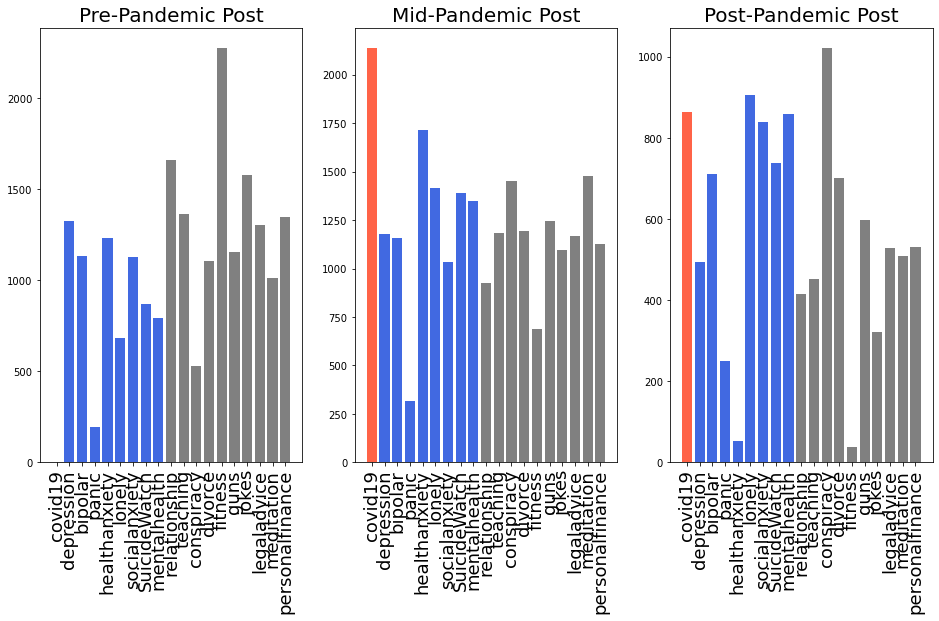

In [ ]:
# 서브레딧 별 게시글의 수 시각화
def subreddit_count(names):
    count_data = np.zeros([3,19], dtype='int')

    count_data[0] = [len(df) for df in ALL_BEF_COVID]
    count_data[1] = [len(df) for df in ALL_MID_COVID]
    count_data[2] = [len(df) for df in ALL_AFT_COVID]
    
    count_data = pd.DataFrame(count_data)
    count_data.columns = names

    count_data = count_data[ENVIRONMENT + MENTAL + NONMENTAL]
    temp = count_data[ENVIRONMENT].sum
    print(count_data[ENVIRONMENT])
    count_data = count_data.T
    count_data.columns = ['Pre-Pandemic Post', 'Mid-Pandemic Post' , 'Post-Pandemic Post']

    colorlist = ['tomato'] + ['royalblue' for i in range(len(MENTAL))] +['gray' for i in range(len(NONMENTAL))]
    
    plt.figure(figsize=(16,8))

    plt.subplot(1,3,1)
    plt.bar(count_data.index, height=count_data['Pre-Pandemic Post'],color=colorlist)

    plt.xticks(names,rotation=90,fontsize= 18)
    plt.title(count_data.columns[0], fontdict = {'fontsize' : 20})

    plt.subplot(1,3,2)
    plt.bar(count_data.index, height=count_data['Mid-Pandemic Post'],color=colorlist)
    plt.xticks(names,rotation=90,fontsize= 18)
    plt.title(count_data.columns[1], fontdict = {'fontsize' : 20})

    plt.subplot(1,3,3)
    plt.bar(count_data.index,height=count_data['Post-Pandemic Post'],color=colorlist)
    plt.xticks(names,rotation=90,fontsize= 18)
    plt.title(count_data.columns[2], fontdict = {'fontsize' : 20})


    return count_data

subreddit_count(names)

Pre-Pandemic Post  Mid-Pandemic Post  Post-Pandemic Post
COVID19                     0               7356               13336
MENTAL                   2136               9552               11552
NON MENTAL                864               4852                5112

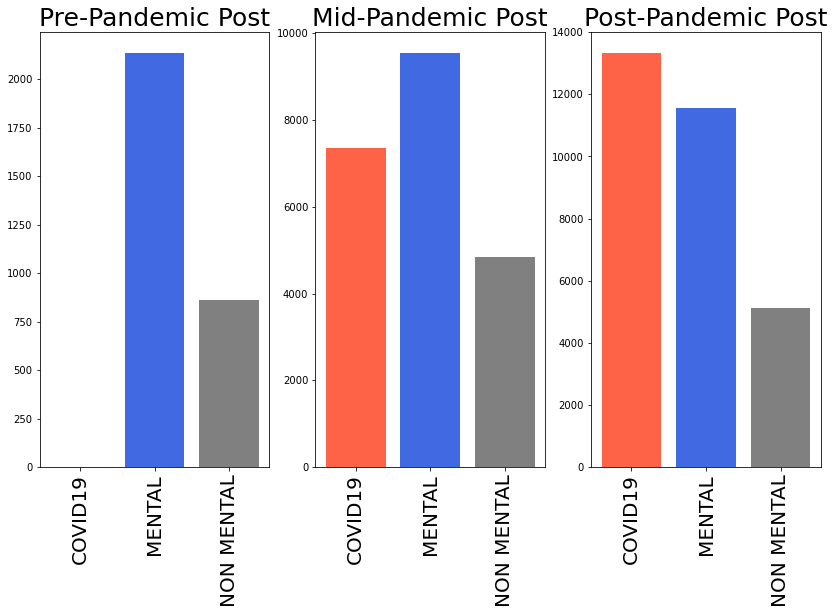

In [41]:
# covid/mental/non-mental 게시글 수 시각화 결과

def mental_count(names):
    count_data = np.zeros([3,19], dtype='int')

    count_data[0] = [len(df) for df in ALL_BEF_COVID]
    count_data[1] = [len(df) for df in ALL_MID_COVID]
    count_data[2] = [len(df) for df in ALL_AFT_COVID]
    
    count_data = pd.DataFrame(count_data)
    count_data.columns = names

    count_data = count_data[ENVIRONMENT + MENTAL + NONMENTAL]
    env_list = np.array([0,0,0])
    ment_list = np.array([0,0,0])
    nonment_list = np.array([0,0,0])

    for i in range(len(names)):
        if names[i] in MENTAL:
            ment_list += count_data[names[i]]
        elif names[i] in NONMENTAL:
            nonment_list += count_data[names[i]]
        else:
            env_list += count_data[names[i]]

    
    count_data = pd.DataFrame([env_list,ment_list,nonment_list])
    count_data.columns = ['COVID19' , 'MENTAL' , 'NON MENTAL']

    # temp['Non Mental Health'] = count_data[NONMENTAL].sum

    # count_data = temp
    count_data = count_data.T
    count_data.columns = ['Pre-Pandemic Post', 'Mid-Pandemic Post' , 'Post-Pandemic Post']

    colorlist = ['tomato'] + ['royalblue'] +['gray']
    
    plt.figure(figsize=(14,8))

    plt.subplot(1,3,1)
    plt.bar(count_data.index, height=count_data['Pre-Pandemic Post'],color=colorlist)
    plt.xticks(['COVID19' , 'MENTAL' , 'NON MENTAL'],rotation=90,fontsize= 20)
    plt.title(count_data.columns[0], fontdict = {'fontsize' : 25})

    plt.subplot(1,3,2)
    plt.bar(count_data.index, height=count_data['Mid-Pandemic Post'],color=colorlist)
    plt.xticks(['COVID19' , 'MENTAL' , 'NON MENTAL'],rotation=90,fontsize= 20)
    plt.title(count_data.columns[1], fontdict = {'fontsize' : 25})

    plt.subplot(1,3,3)
    plt.bar(count_data.index,height=count_data['Post-Pandemic Post'],color=colorlist)
    plt.xticks(['COVID19' , 'MENTAL' , 'NON MENTAL'],rotation=90,fontsize= 20)
    plt.title(count_data.columns[2], fontdict = {'fontsize' : 25})


    return count_data

mental_count(names)

In [24]:
covid_topics = []


covid_topic = pd.read_csv('./sample_dataset/sample_scoring_result/COVID_TOPIC/topic_covid_allsub.csv')
covid_topic
index1 = 0
index2 = 0
for i in range(19):
    index2 = len(allfactor_dfs[i])
    temp = covid_topic[index1:index2]
    print(len(temp))
    covid_topics.append(temp)
len(covid_topics)


3000
3000
760
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000


19

In [25]:
COVID_TOPIC_DF = []
for i in range(19):
    temp = pd.read_csv("./sample_dataset/sample_scoring_result/COVID_TOPIC/" + names[i] +".csv")
    # print(len(temp))
    COVID_TOPIC_DF.append(temp)
len(COVID_TOPIC_DF)

19

In [26]:
# drop_index = [j for j in range(len(ym_datasets[i]))]
    # print(drop_index)
for i in range(6,19):
    tmep_col = list(COVID_TOPIC_DF[i].columns)
    tmep_col[1] = 'level_0'
    COVID_TOPIC_DF[i].columns = tmep_col
COVID_TOPIC_DF[6].columns


Index(['Unnamed: 0', 'level_0', 'subreddit', 'author', 'title', 'text_context',
       'date', 'year', 'month'],
      dtype='object')

In [27]:
COVID_TOPIC_DF[0]['level_0'][3]
drop_indexs = []
for i in range(19):
    drop_index = [j for j in range(len(ym_datasets[i]))]
    # print(drop_index)
    ind = list(COVID_TOPIC_DF[i]['level_0'])
    for j in range(len(ind)):
        drop_index.remove(ind[j])    
    drop_indexs.append(drop_index)

In [28]:
COVID_REL_DF = []
for i in range(19):
    ind =list(COVID_TOPIC_DF[i]['level_0'])
    # drop_index = [j for j in range(len(ym_datasets[i]))]
    # for j in range(len(COVID_TOPIC_DF[i])):
    #     drop_index.remove(drop_indexs[i])
    
    temp = ym_datasets[i].drop(drop_indexs[i])
    COVID_REL_DF.append(temp)


In [29]:
for i in range(19):
    COVID_REL_DF[i].reset_index(drop=True, inplace=True)
COVID_REL_DF[0]

index subreddit                author  \
0     23582   depress          Crowkiller90   
1      8926   depress            Cornjacked   
2      4400   depress               harix04   
3     16153   depress  clair_de_lune_et_ame   
4     14387   depress             S1nth0raS   
...     ...       ...                   ...   
2946  17984   depress               DAMFree   
2947  18096   depress               Refyllz   
2948   4506   depress         nightbookmoon   
2949  20444   depress              dangopam   
2950   1059   depress         Ilovemikal123   

                                                  title  \
0                               Not sure what to do now   
1                           Adderall for mid-day blahs?   
2          Im very scared and nervious making this post   
3                      Helping my friends at my expense   
4     A thought that might help those of you who, li...   
...                                                 ...   
2946                      You think you know depression   
2947  Every time I feel I make progress with my depr...   
2948                  I don't know how long I can go on   
2949                    I've always been a good student   
2950       Boyfriend (24 M) showing depression symptoms   

                                           text_context                 date  \
0     This is really difficult for me to open up and...  2019-06-12 16:25:30   
1     Hey folks. 35 m here. I have been taking Wellb...  2021-02-09 14:19:58   
2     Im a 13 years old teenager can i have depressi...  2021-09-13 05:45:11   
3     I have four good friends. My first one who I’l...  2020-04-05 21:50:54   
4     I’m currently in therapy for depression, but I...  2020-06-21 11:41:14   
...                                                 ...                  ...   
2946  I'm not trying to say I have the worst life I ...  2020-01-19 00:38:24   
2947  Like the title says, no matter how hard I try ...  2020-01-15 03:21:34   
2948  Have no idea where to start \n\nI saw a few ti...  2021-09-07 17:40:17   
2949  I've always been a good student, I had straigh...  2019-10-23 02:43:06   
2950  Long story short: my boyfriend and I (F 23) ha...  2022-02-20 22:25:11   

      year  month  
0     2019      6  
1     2021      2  
2     2021      9  
3     2020      4  
4     2020      6  
...    ...    ...  
2946  2020      1  
2947  2020      1  
2948  2021      9  
2949  2019     10  
2950  2022      2  

[2951 rows x 8 columns]

In [30]:
type(covid_topics[0].loc[0][1])
covid_topics[0]

문서 번호  가장 비중이 높은 토픽  가장 높은 토픽의 비중  \
0         0           1.0        0.9739   
1         1           1.0        0.7510   
2         2           1.0        0.9878   
3         3           1.0        0.8312   
4         4           1.0        0.9930   
...     ...           ...           ...   
2995   2995           1.0        0.9962   
2996   2996           1.0        0.9945   
2997   2997           1.0        0.9531   
2998   2998           1.0        0.9775   
2999   2999           1.0        0.9917   

                                               각 토픽의 비중  
0                                      [(1, 0.9738773)]  
1     [(1, 0.75099057), (3, 0.16008113), (4, 0.07049...  
2                                     [(1, 0.98783314)]  
3                      [(1, 0.831235), (3, 0.15956149)]  
4                                      [(1, 0.9930476)]  
...                                                 ...  
2995                                   [(1, 0.9962201)]  
2996                                  [(1, 0.99454594)]  
2997                 [(1, 0.9531014), (3, 0.043624442)]  
2998                                   [(1, 0.9774831)]  
2999                                   [(1, 0.9916674)]  

[3000 rows x 4 columns]

In [31]:
# split by covid


TOPIC_BEF_COVID = []
TOPIC_MID_COVID = []
TOPIC_AFT_COVID = []


for i in range(len(names)):
    temp = COVID_REL_DF[i]
    TOPIC_BEF_COVID.append(temp[temp['year'] < 2020])
    TOPIC_MID_COVID.append(make_mid_covid_term_df(temp))
    TOPIC_AFT_COVID.append(make_aft_covid_term_df(temp))
    # if (len(temp) != len(YM_BEF_COVID[i])+len(YM_MID_COVID[i])+len(YM_AFT_COVID[i])):
    #     print("Process in making dataset Error : dataset for",names[i])
    #     print('-->', len(YM_BEF_COVID[i]),len(YM_MID_COVID[i]),len(YM_AFT_COVID[i]))
    #     print('-->', len(temp), len(YM_BEF_COVID[i])+len(YM_MID_COVID[i])+len(YM_AFT_COVID[i]))
    #     break

print(len(TOPIC_BEF_COVID),len(TOPIC_MID_COVID),len(TOPIC_AFT_COVID))

for i in range(19):
    TOPIC_BEF_COVID[i].reset_index(drop=True,inplace=True)
    TOPIC_MID_COVID[i].reset_index(drop=True,inplace=True)
    TOPIC_AFT_COVID[i].reset_index(drop=True,inplace=True)
    

19 19 19


/opt/homebrew/Caskroom/miniforge/base/envs/DL-tf/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
ALL_MID_COVID[0].head()

Pre-Pandemic COVID Post  Mid-Pandemic COVID Post  \
covid19                              0.0                 0.077926   
depression                           0.0                 0.049527   
bipolar                              0.0                 0.046041   
panic                                0.0                 0.011618   
healthanxiety                        0.0                 0.056110   
lonely                               0.0                 0.057401   
socialanxiety                        0.0                 0.042943   
SuicideWatch                         0.0                 0.056627   
mentalhealth                         0.0                 0.056153   
relationship                         0.0                 0.039587   
teaching                             0.0                 0.045525   
conspiracy                           0.0                 0.046558   
divorce                              0.0                 0.049914   
fitness                              0.0                 0.023279   
guns                                 0.0                 0.039630   
jokes                                0.0                 0.028141   
legaladvice                          0.0                 0.046429   
meditation                           0.0                 0.052281   
personalfinance                      0.0                 0.043761   

                 Post-Pandemic COVID Post  
covid19                          0.059568  
depression                       0.045068  
bipolar                          0.059660  
panic                            0.019394  
healthanxiety                    0.003694  
lonely                           0.078408  
socialanxiety                    0.073698  
SuicideWatch                     0.064185  
mentalhealth                     0.076745  
relationship                     0.038234  
teaching                         0.038511  
conspiracy                       0.066494  
divorce                          0.062708  
fitness                          0.001662  
guns                             0.041467  
jokes                            0.018378  
legaladvice                      0.044976  
meditation                       0.038788  
personalfinance                  0.044145

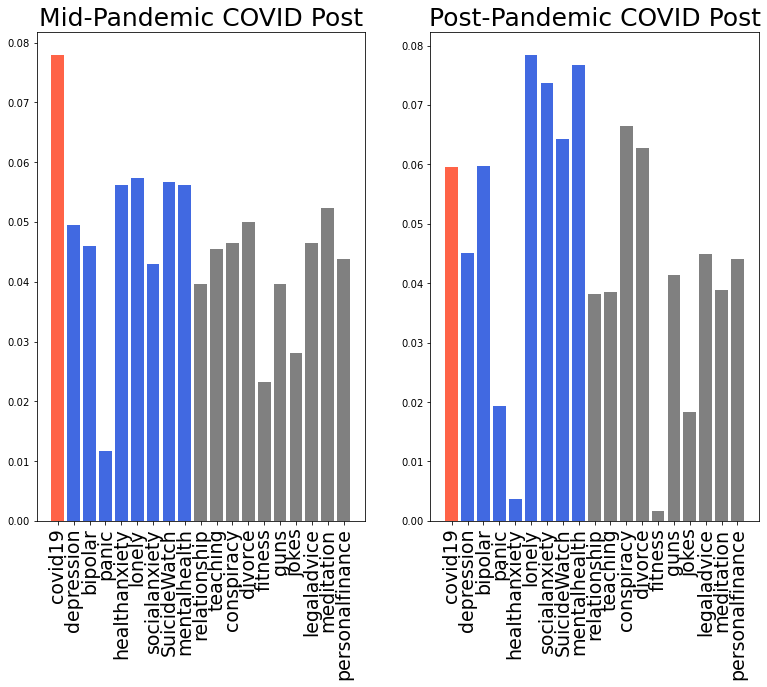

In [37]:
# mid/post 코로나 주제 관련 0.6 이상 게시글 비율 시각화

def covid_topic_rate(names):
    count_data = np.zeros([3,19], dtype='float')
        
    sum_len_all = [0,0,0]
    for i in range(19):
        sum_len_all[1] += len(ALL_MID_COVID[i])
        sum_len_all[2] += len(ALL_AFT_COVID[i])
        
    count_data[1] = [len(df)/sum_len_all[1] for df in TOPIC_MID_COVID]
    count_data[2] = [len(df)/sum_len_all[2] for df in TOPIC_AFT_COVID]

    
    
    count_data = pd.DataFrame(count_data)
    count_data.columns = names

    count_data = count_data[ENVIRONMENT + MENTAL + NONMENTAL]
    count_data = count_data.T
    count_data.columns = ['Pre-Pandemic COVID Post', 'Mid-Pandemic COVID Post' , 'Post-Pandemic COVID Post']

    colorlist = ['tomato'] + ['royalblue' for i in range(len(MENTAL))] +['gray' for i in range(len(NONMENTAL))]
    
    plt.figure(figsize=(20,9))

    plt.subplot(1,3,2)
    plt.bar(count_data.index, height=count_data['Mid-Pandemic COVID Post'],color=colorlist)
    plt.xticks(names,rotation=90,fontsize=19)
    plt.title(count_data.columns[1],fontdict = {'fontsize' : 25})

    plt.subplot(1,3,3)
    plt.bar(count_data.index,height=count_data['Post-Pandemic COVID Post'],color=colorlist)
    plt.xticks(names,rotation=90,fontsize=19)
    plt.title(count_data.columns[2],fontdict = {'fontsize' : 25})

    return count_data

covid_topic_rate(names)

## Category Intensity 분석

### CI - Histogram

In [ ]:
def cat_hist(df):
    fig= plt.figure(figsize=(10,5))

    sns.kdeplot(df['anger'],label = 'anger')
    sns.kdeplot(df['anticipation'],label = 'anticipation')
    sns.kdeplot(df['disgust'],label = 'disgust')
    sns.kdeplot(df['fear'],label = 'fear')
    sns.kdeplot(df['joy'],label = 'joy')
    sns.kdeplot(df['sadness'],label = 'sadness')
    sns.kdeplot(df['surprise'],label = 'surprise')
    sns.kdeplot(df['trust'],label = 'trust')

    plt.legend(['anger','anticipation','disgust','fear','joy','sadness','surprise','trust'])


def cat_hist_by_mental(ci_datasets, names):
    # make datasets
    mental_dataset = pd.DataFrame()
    non_mental_dataset = pd.DataFrame()
    environment_dataset = pd.DataFrame()
    for i in range(len(names)):
        if names[i] in MENTAL:
            mental_dataset = pd.concat([mental_dataset, ci_datasets[i]])
            mental_dataset.reset_index(drop=True,inplace=True)
        elif names[i] in NONMENTAL:
            non_mental_dataset = pd.concat([non_mental_dataset, ci_datasets[i]])
            non_mental_dataset.reset_index(drop=True,inplace=True)
        else: 
            environment_dataset = pd.concat([environment_dataset, ci_datasets[i]])
            environment_dataset.reset_index(drop=True,inplace=True)
    
    print("DATASETS GROUP : ", len(mental_dataset), len(non_mental_dataset), len(environment_dataset))
    # return mental_dataset, non_mental_dataset, environment_dataset
    # plot
    fig, ax = plt.subplots(nrows=8,figsize=(12,20))
    c_lst = [plt.cm.tab10(a) for a in np.linspace(0.0, 1.0, 6)]
    cat = ['anger','anticipation','disgust','fear','joy','sadness','surprise','trust']
    for i in range(8):
        sns.kdeplot(mental_dataset[cat[i]], color = 'seagreen', ax=ax[i], alpha=0.75,linewidth=3)
        sns.kdeplot(non_mental_dataset[cat[i]], color = 'tomato', ax=ax[i], alpha=0.75,linewidth=3)
        sns.kdeplot(environment_dataset[cat[i]], color = 'royalblue', ax=ax[i], alpha=0.75,linewidth=3)
        
        ax[i].legend(['Mental Health','Non-mental Heealth','COVID19'])
        ax[i].set_title(cat[i])
        ax[i].set(xlim=(-0.1, 1.1)) 
    





In [ ]:
(ci_datasets[0].iloc[0][5:])

anger           0.163068
anticipation    0.015998
disgust         0.069805
fear            0.232505
joy             0.129054
sadness         0.185269
surprise        0.050982
trust           0.153318
Name: 0, dtype: object

DATASETS GROUP :  21760 30000 3000


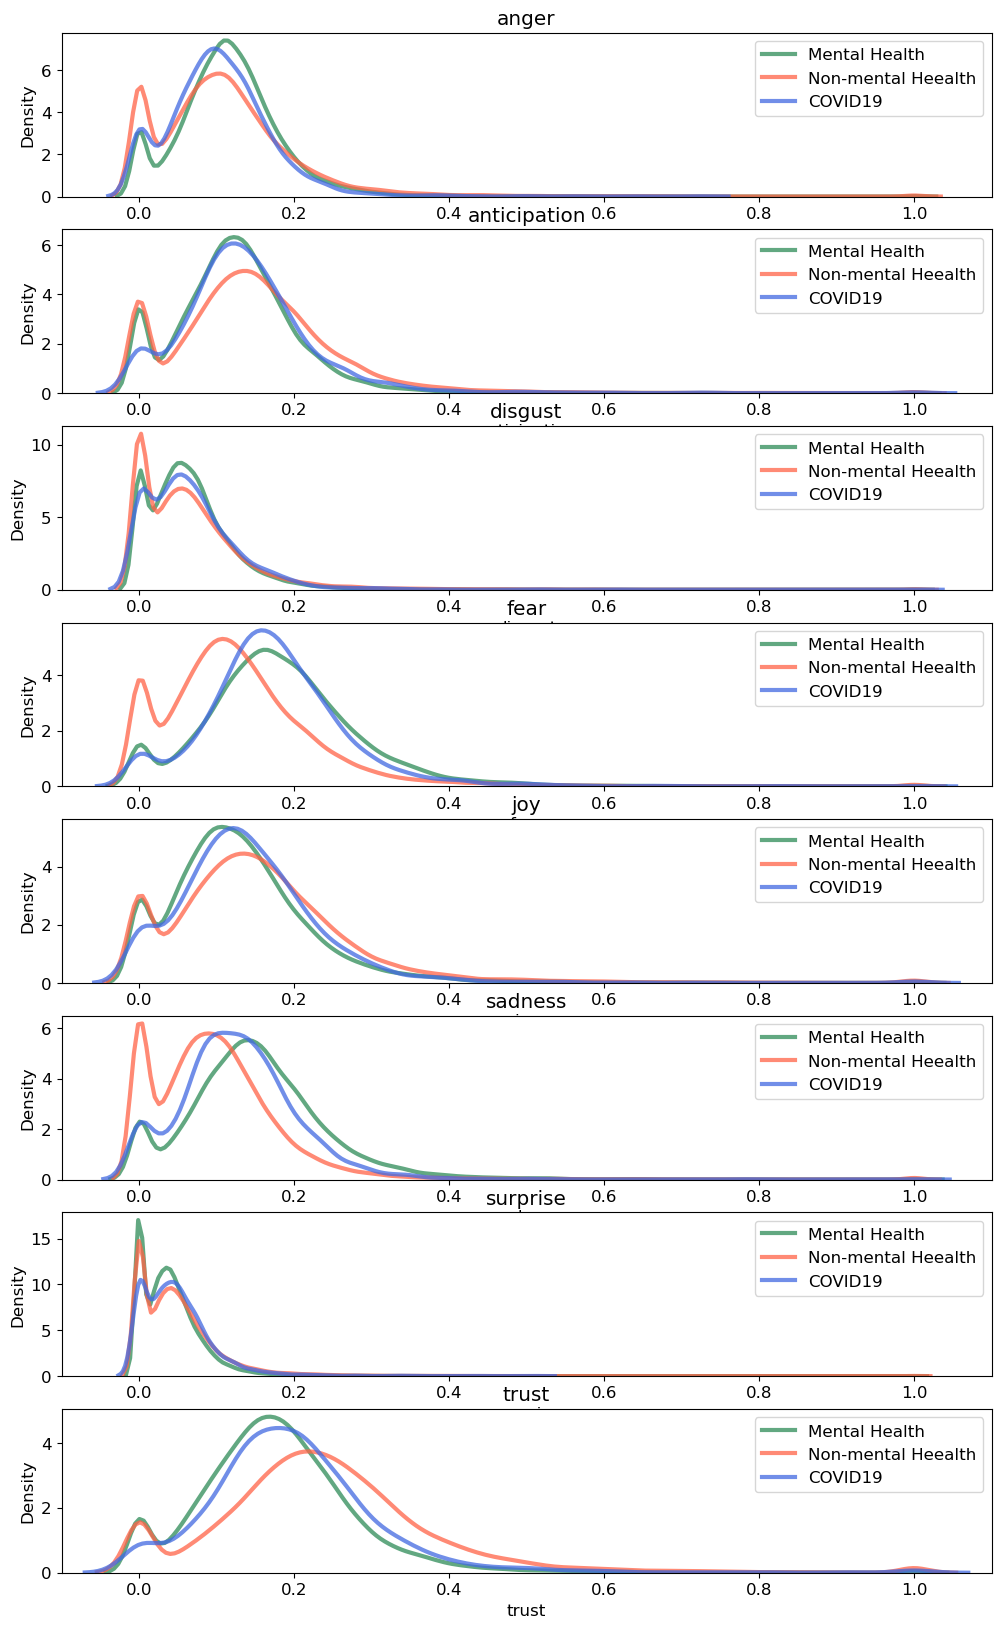

In [ ]:
cat_hist_by_mental(ci_datasets, names)

### CI - BoxPlot

In [ ]:
def cat_box_by_all_red(ci_datasets, names):
    fig, ax = plt.subplots(nrows=8,figsize=(12,100),sharex=True, sharey=True)

    cat = ['anger','anticipation','disgust','fear','joy','sadness','surprise','trust']
    # datasets = []
    env= []
    ment= []
    nonm= []
    for i in range(8):
        for j in range(len(ci_datasets)):
            if names[j] in ENVIRONMENT:
                temp = ci_datasets[j][cat[i]]
                env.append(temp)
            elif names[j] in MENTAL:
                temp = ci_datasets[j][cat[i]]
                ment.append(temp)
            else:
                temp = ci_datasets[j][cat[i]]
                nonm.append(temp)
        datasets = env + ment + nonm
        ax[i].boxplot(datasets, notch=True,vert=False)
        ax[i].set_xlim(-.1, 1.1)
        ax[i].set_yticks(np.arange(1, len(ci_datasets)+1))
        ax[i].set_yticklabels(ENVIRONMENT + MENTAL + NONMENTAL)
        ax[i].set_title(cat[i],fontdict = {'fontsize' : 20})
        ax[i].axvline(x= datasets[3].median(), color='r', linestyle='--', linewidth=1)


In [61]:
def cat_box_by_all_red(ci_datasets, names):
    fig, ax = plt.subplots(nrows=8,figsize=(12,100),sharex=True, sharey=True)

    cat = ['anger','anticipation','disgust','fear','joy','sadness','surprise','trust']
    datasets = []

    for i in range(8):
        datasets = []
        for j in range(len(ci_datasets)):
            temp = ci_datasets[j][cat[i]]
            datasets.append(temp)
        ax[i].boxplot(datasets, notch=True,vert=False)
        ax[i].set_xlim(-.1, 1.1)
        ax[i].set_yticks(np.arange(1, len(ci_datasets)+1))
        ax[i].set_yticklabels(names,fontsize=15)
        ax[i].set_title(cat[i],fontdict = {'fontsize' : 25})
        ax[i].axvline(x= datasets[3].median(), color='r', linestyle='--', linewidth=1)

def cat_box_by_mental(ci_datasets, names):
    # make datasets
    mental_dataset = pd.DataFrame()
    non_mental_dataset = pd.DataFrame()
    environment_dataset = pd.DataFrame()
    for i in range(len(names)):
        if names[i] in MENTAL:
            mental_dataset = pd.concat([mental_dataset, ci_datasets[i]])
        elif names[i] in NONMENTAL:
            non_mental_dataset = pd.concat([non_mental_dataset, ci_datasets[i]])
        else: 
            environment_dataset = pd.concat([environment_dataset, ci_datasets[i]])
    
    print("DATASETS GROUP : ", len(mental_dataset), len(non_mental_dataset), len(environment_dataset))
    
    # plot
    fig, ax = plt.subplots(nrows=8,figsize=(12,45),sharex=True, sharey=True)
    # c_lst = [plt.cm.viridis(a) for a in np.linspace(0.0, 1.0, 5)]
    cat = ['anger','anticipation','disgust','fear','joy','sadness','surprise','trust']
    for i in range(8):
        data_m = mental_dataset[cat[i]]
        data_nm = non_mental_dataset[cat[i]]
        data_en = environment_dataset[cat[i]]
        ax[i].boxplot([data_m, data_nm,data_en], notch=True,vert=False)
        # ax[i].violinplot([data_m, data_nm,data_en],vert=False)#, notch=True,vert=False)
        ax[i].set_xlim(-.1, 1.1)
        ax[i].set_yticks(np.arange(1, 4))
        ax[i].set_yticklabels(['Mental Health','Non-mental\nHeealth','COVID19'],fontsize=25)
        ax[i].set_title(cat[i],fontdict = {'fontsize' : 40})
        ax[i].axvline(x= data_en.median(), color='r', linestyle='--', linewidth=1)

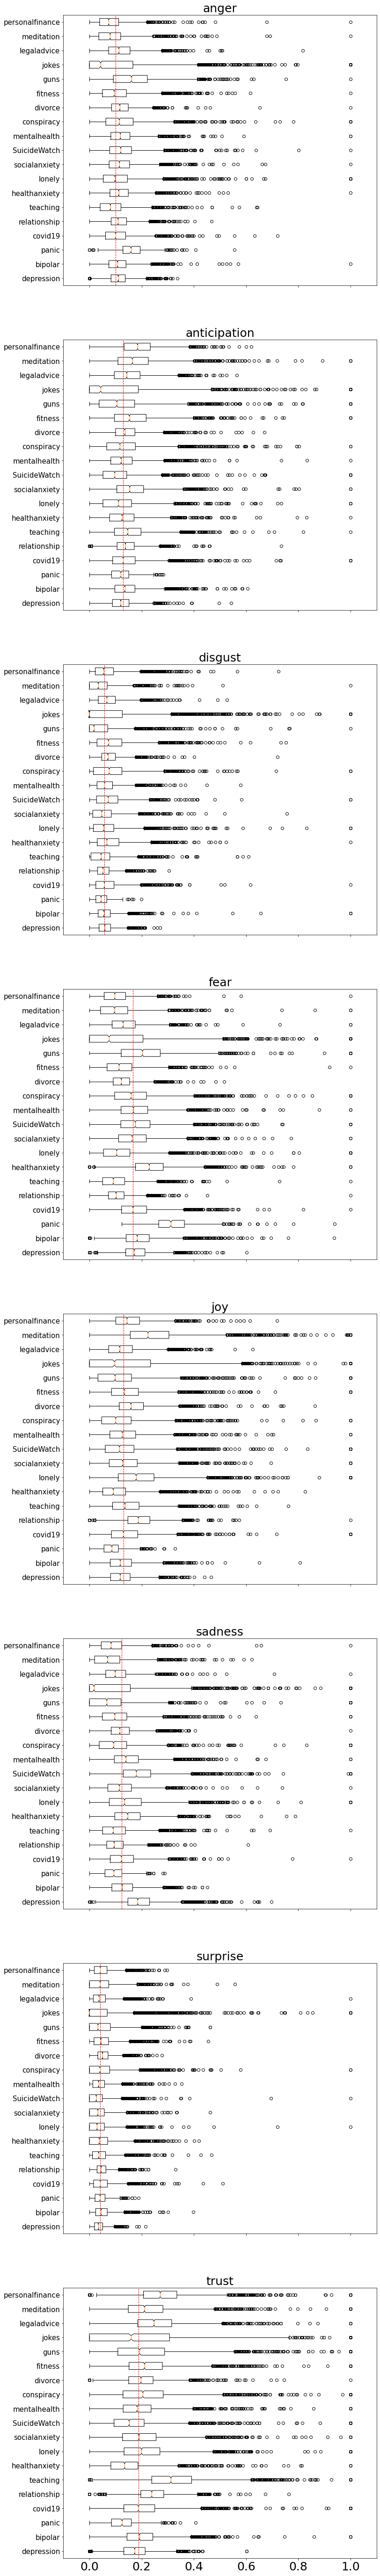

In [ ]:
cat_box_by_all_red(ci_datasets, names)

DATASETS GROUP :  21760 30000 3000


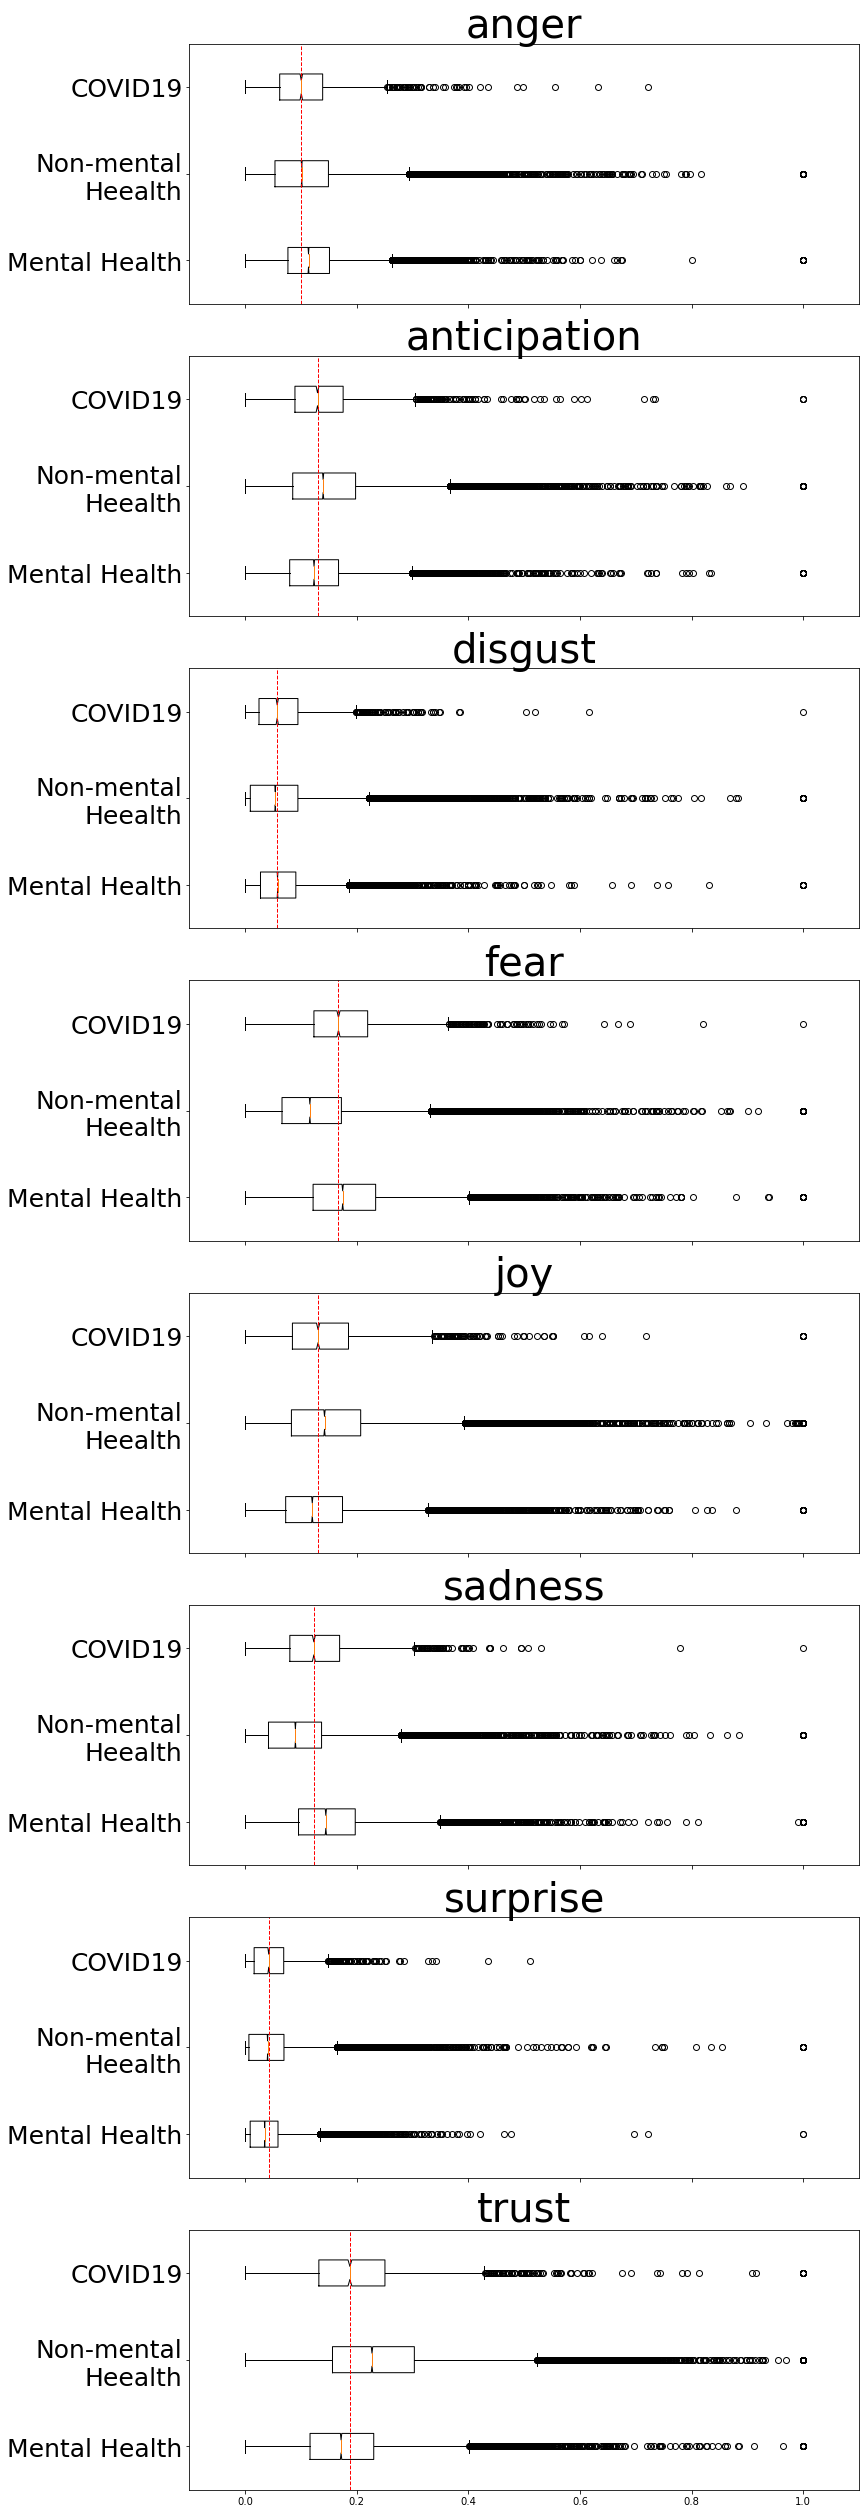

In [62]:
cat_box_by_mental(ci_datasets, names)

## Valence Arousal 분석

### VA - Histogram

#### 코로나 기간별 / 서브레딧 각각 


In [ ]:
def va_hist(df):
    fig, ax = plt.subplots(nrows=2,sharex=True, sharey=True)

    sns.kdeplot(df['avgPV'], ax=ax[0],label='Valence-Positive')
    sns.kdeplot(df['avgNV']*(-1), ax=ax[0],label='Valence-Negative')
    sns.kdeplot(df['avgPA'], ax=ax[1],label='Arousal-Positive')
    sns.kdeplot(df['avgNA']*(-1), ax=ax[1],label='Arousal-Negative')

    for i in range(2):
      ax[i].legend(bbox_to_anchor=(1.0, 1.0))
      ax[i].set_xlim([-1.2,1.2])

##### 결과물 확인

In [ ]:
subreddit_index = 6
print(names[subreddit_index])

healthanxiety


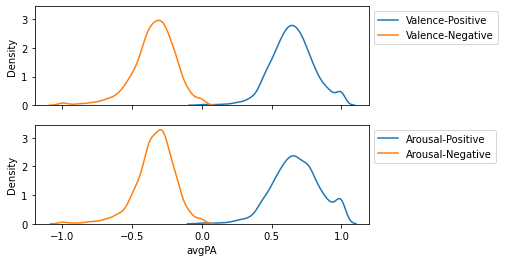

In [ ]:
va_hist(allfactor_dfs[subreddit_index]) 

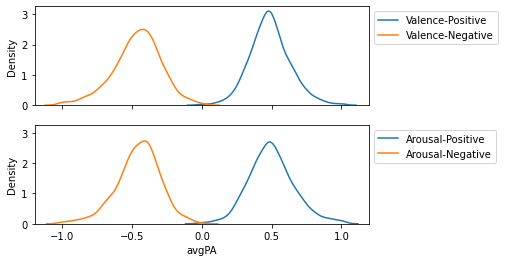

In [ ]:
va_hist(ALL_BEF_COVID[subreddit_index]) 

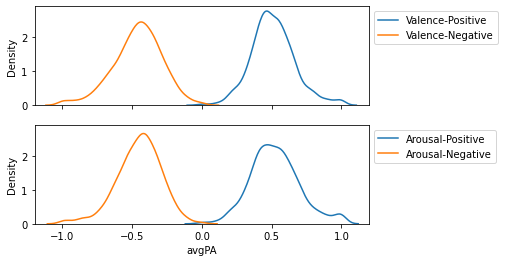

In [ ]:
va_hist(ALL_MID_COVID[subreddit_index]) 

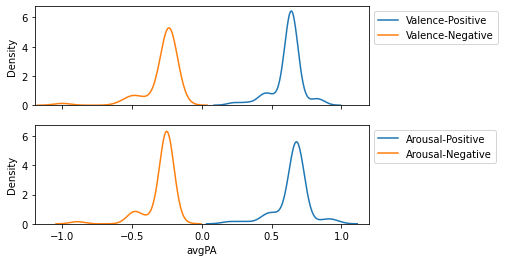

In [ ]:
va_hist(ALL_AFT_COVID[subreddit_index]) 

socialanxiety


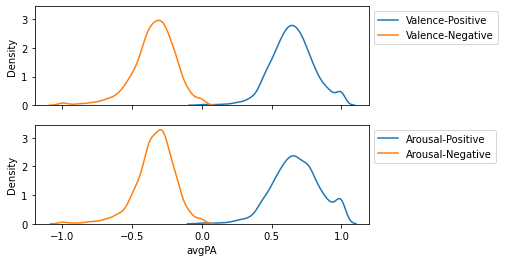

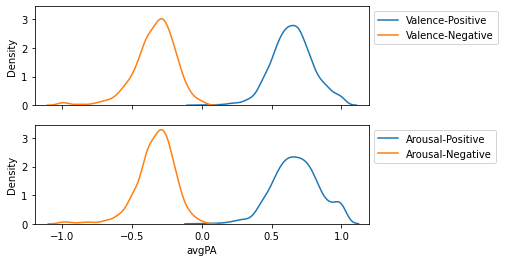

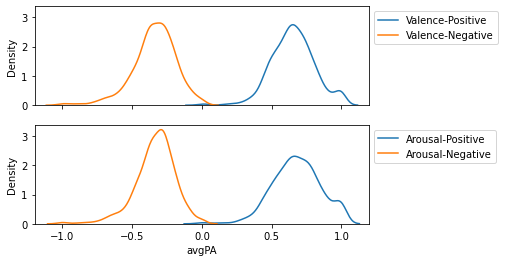

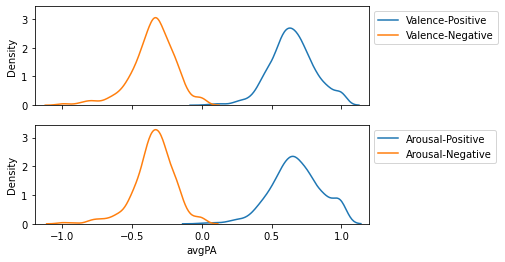

In [ ]:
subreddit_index = 8
print(names[subreddit_index])
va_hist(allfactor_dfs[subreddit_index]) 
va_hist(ALL_BEF_COVID[subreddit_index]) 
va_hist(ALL_MID_COVID[subreddit_index]) 
va_hist(ALL_AFT_COVID[subreddit_index]) 

#### 정신 관련 subrddit 별로 그룹화 

In [81]:
## 정신질환 / 코로나 / 비정신질환 나누어  표현

from cProfile import label
def va_hist_by_mental(va_datasets,names):
    # make datasets
    mental_dataset = pd.DataFrame()
    non_mental_dataset = pd.DataFrame()
    environment_dataset = pd.DataFrame()
    for i in range(len(names)):
        if names[i] in MENTAL:
            mental_dataset = pd.concat([mental_dataset, va_datasets[i]])
            mental_dataset.reset_index(drop=True,inplace=True)
        elif names[i] in NONMENTAL:
            non_mental_dataset = pd.concat([non_mental_dataset, va_datasets[i]])
            non_mental_dataset.reset_index(drop=True,inplace=True)
        else: 
            environment_dataset = pd.concat([environment_dataset, va_datasets[i]])
            environment_dataset.reset_index(drop=True,inplace=True)
    

    fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(15, 8),sharex=True, sharey=True)

    sns.kdeplot(mental_dataset['avgPV'],ax=ax[0][0],label='Mental Health - Positive')
    sns.kdeplot(mental_dataset['avgNV']*(-1),ax=ax[0][0],label='Mental Health - Negative')
    sns.kdeplot(environment_dataset['avgPV'],ax=ax[1][0],label='COVID19 - Positive')
    sns.kdeplot(environment_dataset['avgNV']*(-1),ax=ax[1][0],label='COVID19 - Negative')
    sns.kdeplot(non_mental_dataset['avgPV'],ax=ax[2][0],label='NonMental - Positive')
    sns.kdeplot(non_mental_dataset['avgNV']*(-1),ax=ax[2][0],label='NonMental - Negative')

    sns.kdeplot(mental_dataset['avgPA'],ax=ax[0][1],label='Mental Health - High')
    sns.kdeplot(mental_dataset['avgNA']*(-1),ax=ax[0][1],label='Mental Health - Low')
    sns.kdeplot(environment_dataset['avgPA'],ax=ax[1][1],label='COVID19 - High')
    sns.kdeplot(environment_dataset['avgNA']*(-1),ax=ax[1][1],label='COVID19 - Low')
    sns.kdeplot(non_mental_dataset['avgPA'],ax=ax[2][1],label='NonMental - High')
    sns.kdeplot(non_mental_dataset['avgNA']*(-1),ax=ax[2][1],label='NonMental - Low')
    for i in range(3):
        ax[i][0].axvline(x= environment_dataset['avgPV'].median(), color='r', linestyle='--', linewidth=1)
        ax[i][0].axvline(x= environment_dataset['avgNV'].median()*(-1), color='r', linestyle='--', linewidth=1)
        ax[i][1].axvline(x= environment_dataset['avgPA'].median(), color='r', linestyle='--', linewidth=1)
        ax[i][1].axvline(x= environment_dataset['avgNA'].median()*(-1), color='r', linestyle='--', linewidth=1)

    ax[2][0].set_xlabel('Valence',fontdict={'fontsize' : 25})
    ax[2][1].set_xlabel('Arousal',fontdict={'fontsize' : 25})

    for i in range(3):
        ax[i][1].legend(bbox_to_anchor=(1.7, 1.0),prop={'size': 18})


##### 결과물 확인

In [82]:
subreddit_index = 0
print(names[subreddit_index])

depression


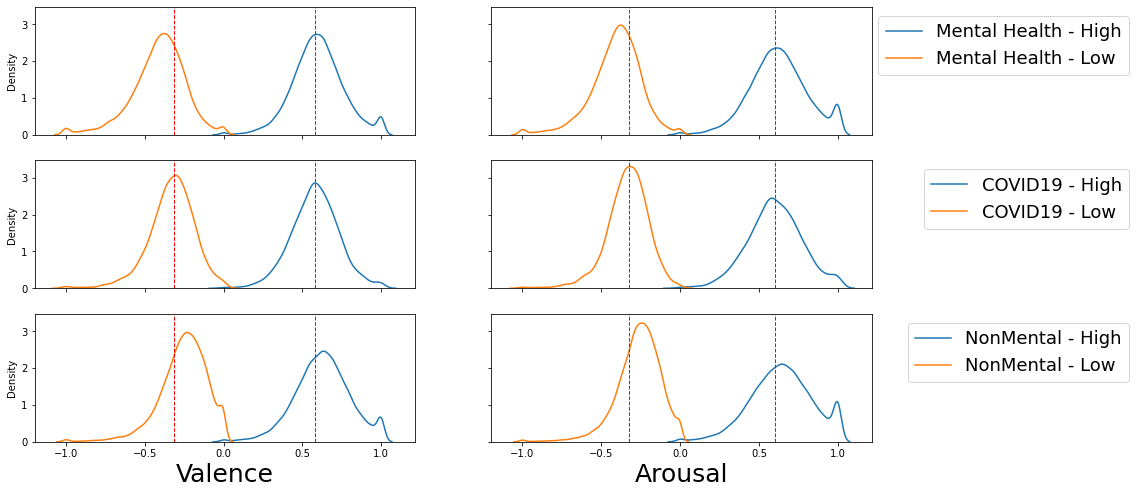

In [83]:
va_hist_by_mental(allfactor_dfs,names) # 코로나 기간 pre/mid/post 전체 - 최종 결과에 활용

No handles with labels found to put in legend.


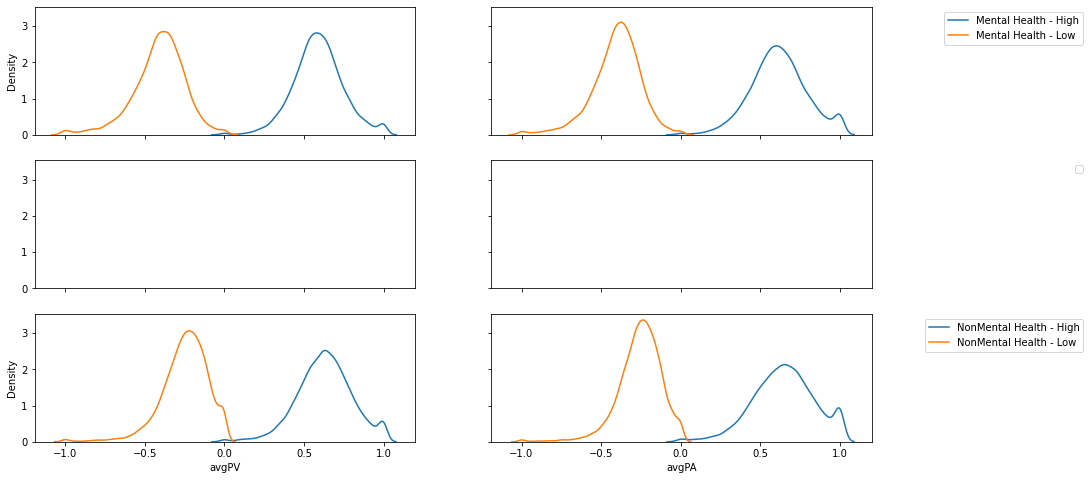

In [ ]:
# pre-pandemic
va_hist_by_mental(ALL_BEF_COVID,names) 

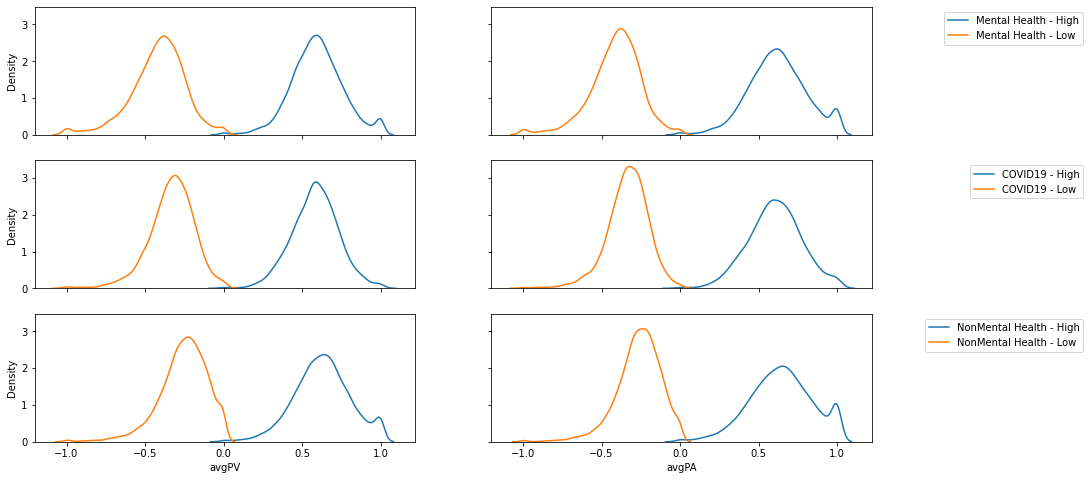

In [ ]:
# mid-pandemic
va_hist_by_mental(ALL_MID_COVID,names) 

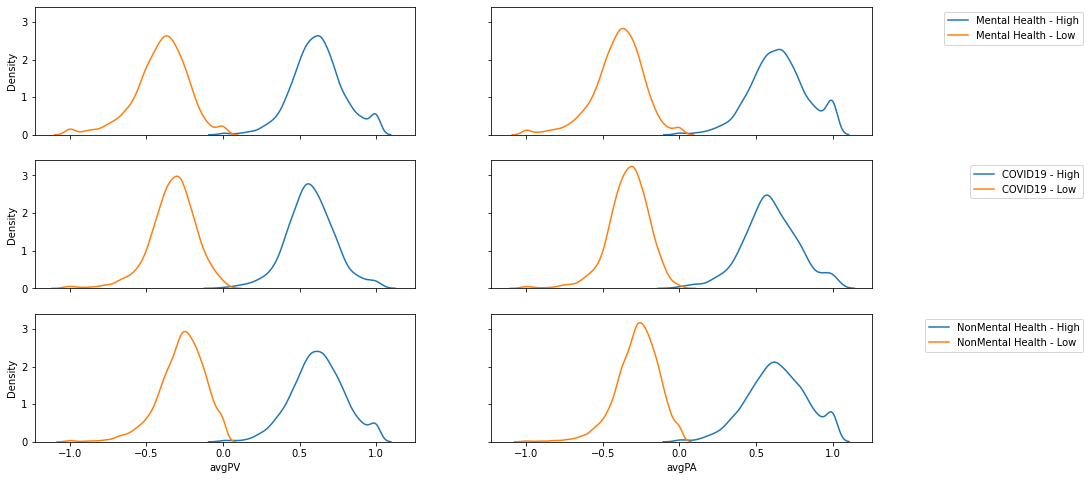

In [ ]:
# post-pandemic
va_hist_by_mental(ALL_AFT_COVID,names) 

### VA - Violin

depression


/var/folders/sl/qqf_xzvs6zddpqnd586m66p80000gn/T/ipykernel_1075/355612655.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_df[negative_item] *= (-1)


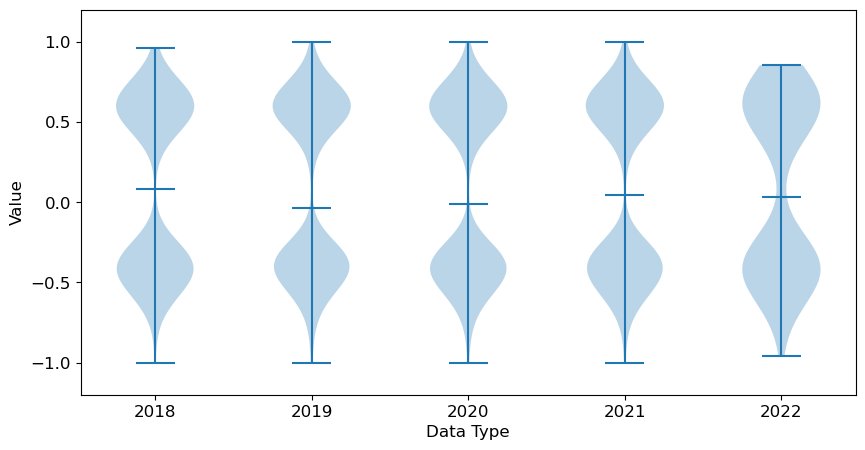

In [ ]:
def va_violin_by_time(df, time_seg, positive_item, negative_item):
     # 데이터셋 구성
     plot_df_columns = [time_seg,'score']
     
     positive_columns = [time_seg, positive_item]
     positive_df = df[positive_columns] 
     positive_df.columns = plot_df_columns
     
     negative_columns = [time_seg, negative_item]
     negative_df = df[negative_columns]
     negative_df[negative_item] *= (-1)
     negative_df.columns = plot_df_columns

     plot_df = pd.concat([positive_df,negative_df]).reset_index(drop=True)

     # 데이터셋 나누기
     seg_df = []
     time_columns =np.sort(plot_df[time_seg].unique())
     for ts in time_columns:
          temp_df = plot_df[plot_df[time_seg] == ts]
          seg_df.append(temp_df)
     
     
     # 그래프 기본 스타일 설정
     plt.style.use('default')
     plt.rcParams['figure.figsize'] = (10,5)
     plt.rcParams['font.size'] = 12
     

     # 그래프 그리기
     fig, ax = plt.subplots()

     violin = ax.violinplot([list(DF['score']) for DF in seg_df], showmedians=True)
     
     ax.set_ylim(-1.2, 1.2)
     ax.set_xticks(np.arange(1, len(seg_df) + 1))
     ax.set_xticklabels(time_columns,rotation =0)
     ax.set_xlabel('Data Type')
     ax.set_ylabel('Value')

     plt.show()

subreddit_index = 0
temp = allfactor_dfs[subreddit_index]
print(names[subreddit_index])
va_violin_by_time(temp, 'year', 'avgPV', 'avgNV')

/var/folders/sl/qqf_xzvs6zddpqnd586m66p80000gn/T/ipykernel_1075/355612655.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_df[negative_item] *= (-1)


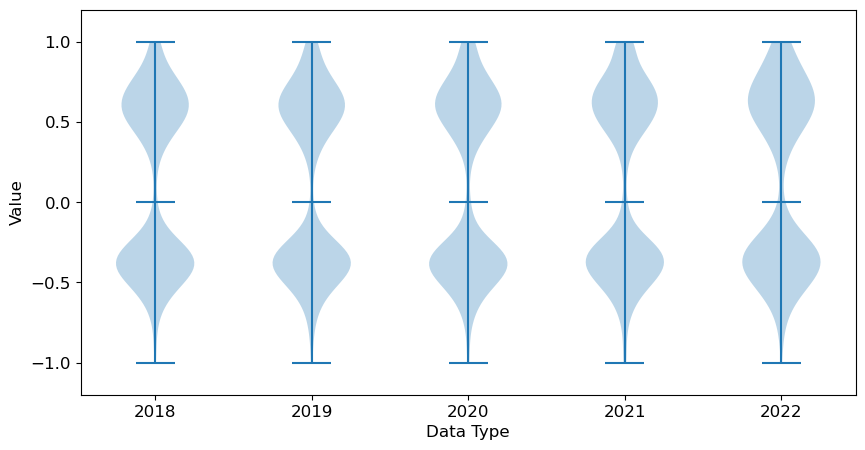

Mental health subreddits


In [ ]:
mental_indexs = []
nonmental_indexs = []
for i in range(len(names)):
    if names[i] in MENTAL:
        mental_indexs.append(i)
    elif names[i] in NONMENTAL:
        nonmental_indexs.append(i)

temp1 = pd.concat([allfactor_dfs[i] for i in mental_indexs])
va_violin_by_time(temp1, 'year', 'avgPA', 'avgNA')
print("Mental health subreddits")


In [ ]:

temp2 = pd.concat([allfactor_dfs[i] for i in nonmental_indexs])
print("Non Mental health subreddits")
va_violin_by_time(temp, 'year', 'avgPV', 'avgNV')

depression


/var/folders/sl/qqf_xzvs6zddpqnd586m66p80000gn/T/ipykernel_1075/355612655.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_df[negative_item] *= (-1)


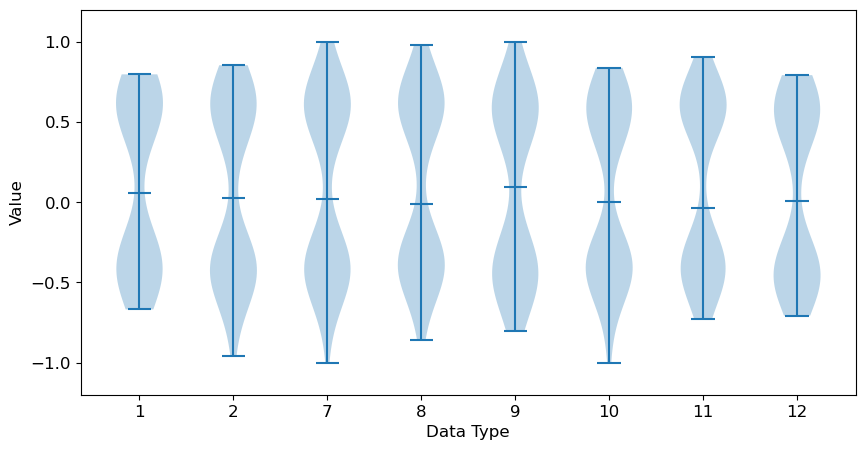

In [ ]:
subreddit_index = 0
temp = ALL_AFT_COVID[subreddit_index]
print(names[subreddit_index])
va_violin_by_time(temp, 'month', 'avgPV', 'avgNV')

covid19


/var/folders/sl/qqf_xzvs6zddpqnd586m66p80000gn/T/ipykernel_1075/355612655.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_df[negative_item] *= (-1)


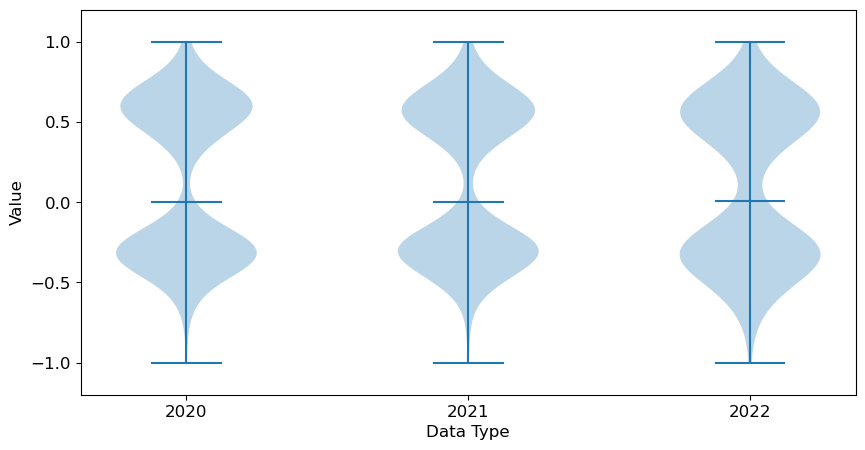

In [ ]:
subreddit_index = 3
temp3 = allfactor_dfs[subreddit_index]
print(names[subreddit_index])
va_violin_by_time(temp3, 'year', 'avgPV', 'avgNV')

3000 [0.5989993580032495, -0.32491816785813515]


/var/folders/sl/qqf_xzvs6zddpqnd586m66p80000gn/T/ipykernel_1075/1057988144.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_df[negative_item] *= (-1)


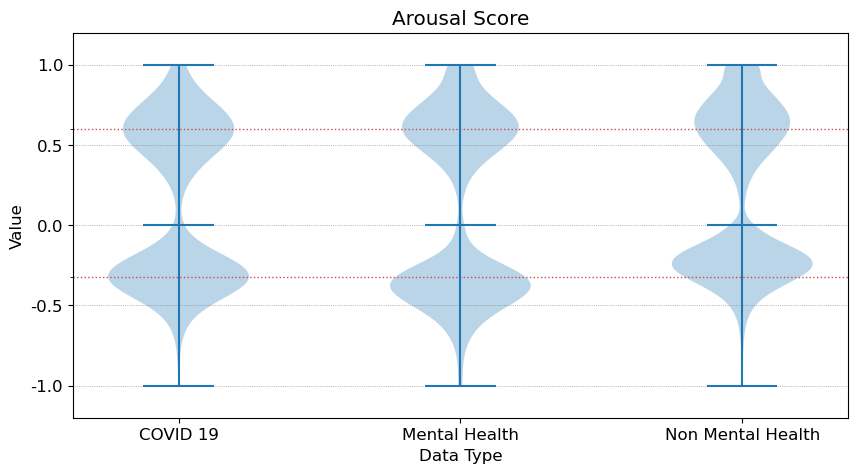

In [ ]:
def va_violin_by_covid(df, time_seg, positive_item, negative_item):
     # 데이터셋 구성
     plot_df_columns = [time_seg,'score']
     
     positive_columns = [time_seg, positive_item]
     positive_df = df[positive_columns] 
     positive_df.columns = plot_df_columns
     
     negative_columns = [time_seg, negative_item]
     negative_df = df[negative_columns]
     negative_df[negative_item] *= (-1)
     negative_df.columns = plot_df_columns  

     plot_df = pd.concat([positive_df,negative_df]).reset_index(drop=True)

     minor_yticks=[]
     temp_df = positive_df[positive_df[time_seg] == 'COVID 19']
     minor_yticks.append(temp_df['score'].median())
     temp_df = negative_df[negative_df[time_seg] == 'COVID 19']
     minor_yticks.append(temp_df['score'].median()) 
     
     print(len(temp_df),minor_yticks)
     # 데이터셋 나누기
     seg_df = []
     time_columns =np.sort(plot_df[time_seg].unique())

     for ts in time_columns:
          temp_df = plot_df[plot_df[time_seg] == ts]
          seg_df.append(temp_df)
     
     
     
     # 그래프 기본 스타일 설정
     plt.style.use('default')
     plt.rcParams['figure.figsize'] = (10,5)
     plt.rcParams['font.size'] = 12
     

     # 그래프 그리기
     fig, ax = plt.subplots()
     ytick_labels = [str(i) for i in [-1.,-.5,0.,.5,1.0]]
     ax.set_yticks(minor_yticks,minor=True)
     ax.set_yticks([-1.,-.5,0.,.5,1.0])
     ax.set_yticklabels(ytick_labels)
     ax.grid(axis ='y',linewidth=.5,linestyle=':',color='gray',which='major')
     ax.grid(axis ='y',linewidth=1.,linestyle=':',color='r',which='minor')
     violin = ax.violinplot([list(DF['score']) for DF in seg_df], showmedians=True)
     
     # mean_list = [np.mean(DF['score']) for DF in seg_df]
     # ax.plot(time_columns, mean_list, marker = 'o', color='red', label='mean')
     
     ax.set_ylim(-1.2, 1.2)
     ax.set_xticks(np.arange(1, len(seg_df) + 1))
     ax.set_xticklabels(time_columns,rotation =0)
     ax.set_xlabel('Data Type')
     ax.set_ylabel('Value')

     plt.title('Arousal Score')

     plt.show()


temp1['class'] = ['Mental Health' for i in range(len(temp1))]
temp2['class'] = ['Non Mental Health' for i in range(len(temp2))]
temp3['class'] = ['COVID 19' for i in range(len(temp3))]

tlqkf = pd.concat([temp1,temp2,temp3])
va_violin_by_covid(tlqkf, 'class', 'avgPA', 'avgNA')

In [ ]:
def va_violin_by_reddits(datasets, names, positive_item, negative_item,title):
     # 데이터셋 구성
     plot_df_columns = ['date','year','month','hour', 'score']
     
     plot_dfs = []
     minor_yticks = []
     for i in range(len(datasets)):
          positive_columns = ['date','year','month','hour', positive_item]
          positive_df = datasets[i][positive_columns] 
          positive_df.columns = plot_df_columns
        
          negative_columns = ['date','year','month','hour', negative_item]
          negative_df = datasets[i][negative_columns]
          negative_df[negative_item] *= (-1)
          negative_df.columns = plot_df_columns

          if i ==3:
               minor_yticks.append(positive_df['score'].median())
               minor_yticks.append(negative_df['score'].median())             

          plot_df = pd.concat([positive_df,negative_df]).reset_index(drop=True)
          plot_dfs.append(plot_df)

     # plot 순서 변경
     mental = []
     nonmental = []
     environment = []
     for j in range(len(names)):
          if names[j] in MENTAL:
               mental.append(plot_dfs[j])
          elif names[j] in NONMENTAL:
               nonmental.append(plot_dfs[j])
          else:
               environment.append(plot_dfs[j])
     plot_dfs = mental + environment + nonmental
     
     # 그래프 기본 스타일 설정
     plt.style.use('default')
     plt.rcParams['figure.figsize'] = (10,5)
     plt.rcParams['font.size'] = 12

          
     # 그래프 그리기
     fig, ax = plt.subplots()
     
     ytick_labels = [str(i) for i in [-1.,-.5,0.,.5,1.0]]
     ax.set_yticks(minor_yticks,minor=True)
     ax.set_yticks([-1.,-.5,0.,.5,1.0])
     ax.set_yticklabels(ytick_labels)
     ax.grid(axis ='y',linewidth=.5,linestyle=':',color='gray',which='major')
     ax.grid(axis ='y',linewidth=1.,linestyle=':',color='r',which='minor')
     violin = ax.violinplot([list(df['score']) for df in plot_dfs], showmedians=True)


     # for m in range(len(MENTAL)):
     #      violin['bodies'][m].set_facecolor('blue')
     
     violin['bodies'][len(MENTAL)].set_facecolor('red')

     for nm in range(len(MENTAL)+1, 19):
          violin['bodies'][nm].set_facecolor('gray')
     
     # mean_list = [np.mean(DF['score']) for DF in seg_df]
     # ax.plot(time_columns, mean_list, marker = 'o', color='red', label='mean')
     
     ax.set_ylim(-1.2, 1.2)
     ax.set_xticks(np.arange(1, len(plot_dfs) + 1))
     ax.set_xticklabels(MENTAL + ENVIRONMENT + NONMENTAL,rotation = 90)
     ax.set_xlabel('Data Type')
     ax.set_ylabel('Value')
     plt.title(title)
     plt.show()



In [ ]:
def va_violin_by_reddits_befcov(datasets, names, positive_item, negative_item):
     # 데이터셋 구성
     plot_df_columns = ['date','year','month','hour', 'score']
     
     plot_dfs = []
     indexes = []
     for i in range(len(datasets)):
          if i== 3 : continue
          else:
               indexes.append(i)
               positive_columns = ['date','year','month','hour', positive_item]
               positive_df = datasets[i][positive_columns] 
               positive_df.columns = plot_df_columns
          
               negative_columns = ['date','year','month','hour', negative_item]
               negative_df = datasets[i][negative_columns]
               negative_df[negative_item] *= (-1)
               negative_df.columns = plot_df_columns

               plot_df = pd.concat([positive_df,negative_df]).reset_index(drop=True)
               plot_dfs.append(plot_df)

     # plot 순서 변경
     mental = []
     nonmental = []
     environment = []
     for j in range(len(plot_dfs)):
          if names[indexes[j]] in MENTAL:
               mental.append(plot_dfs[j])
          elif names[indexes[j]] in NONMENTAL:
               nonmental.append(plot_dfs[j])
          else:
               environment.append(plot_dfs[j])
               
     plot_dfs = mental + nonmental
     
     # 그래프 기본 스타일 설정
     plt.style.use('default')
     plt.rcParams['figure.figsize'] = (10,5)
     plt.rcParams['font.size'] = 12
     

     # 그래프 그리기
     fig, ax = plt.subplots()
     ax.grid(axis ='y',linewidth=.5,linestyle=':')
     violin = ax.violinplot([list(df['score']) for df in plot_dfs], showmedians=True)

     # for m in range(len(MENTAL)):
     #      violin['bodies'][m].set_facecolor('blue')
     

     for nm in range(len(MENTAL), 18):
          violin['bodies'][nm].set_facecolor('gray')
     
     # mean_list = [np.mean(DF['score']) for DF in seg_df]
     # ax.plot(time_columns, mean_list, marker = 'o', color='red', label='mean')
     
     ax.set_ylim(-1.2, 1.2)
     ax.set_xticks(np.arange(1, len(plot_dfs) + 1))
     ax.set_xticklabels(MENTAL + NONMENTAL,rotation = 90)
     ax.set_xlabel('Data Type')
     ax.set_ylabel('Value')

     # plt.title(title)
     plt.show()



/var/folders/sl/qqf_xzvs6zddpqnd586m66p80000gn/T/ipykernel_1075/1582397143.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_df[negative_item] *= (-1)
/var/folders/sl/qqf_xzvs6zddpqnd586m66p80000gn/T/ipykernel_1075/1582397143.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_df[negative_item] *= (-1)


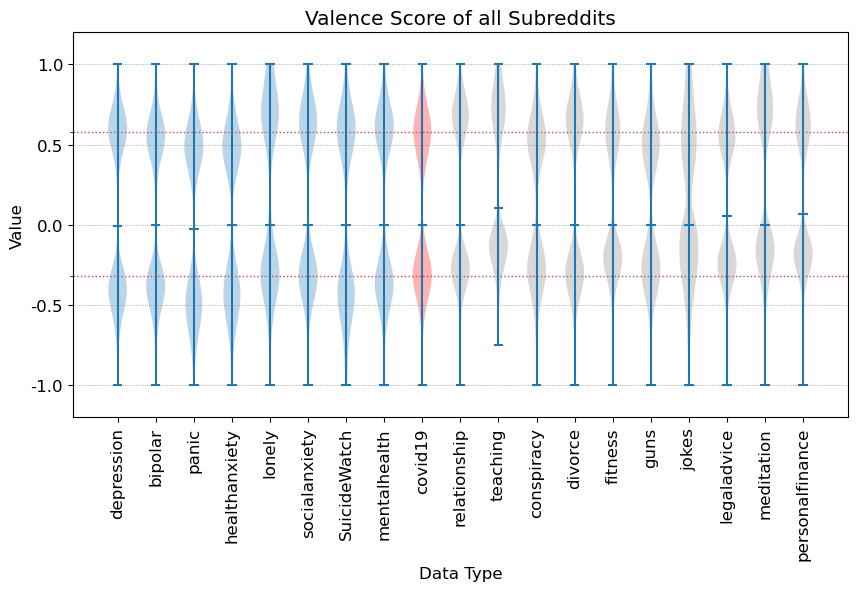

In [ ]:
va_violin_by_reddits(allfactor_dfs, names, 'avgPV', 'avgNV','Valence Score of all Subreddits')

/var/folders/sl/qqf_xzvs6zddpqnd586m66p80000gn/T/ipykernel_1075/3544127020.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_df[negative_item] *= (-1)


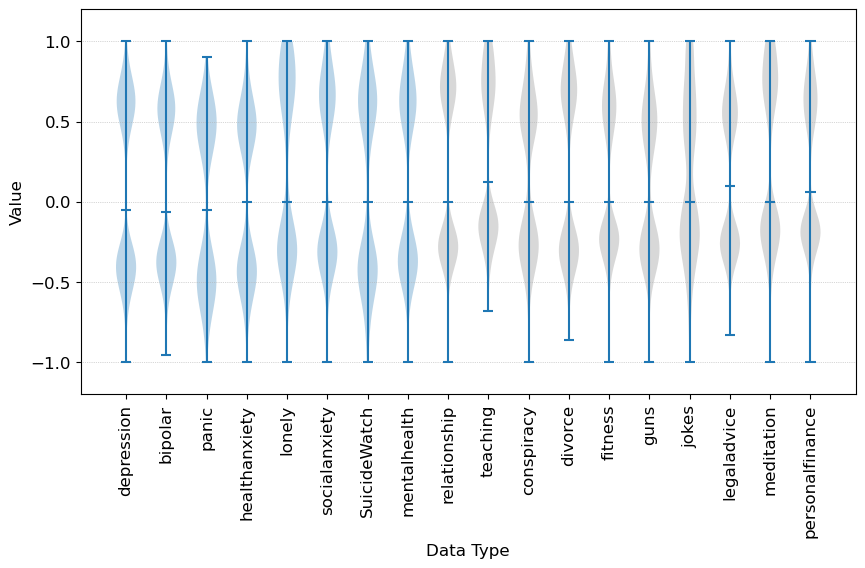

In [ ]:
va_violin_by_reddits_befcov(ALL_BEF_COVID, names, 'avgPA', 'avgNA')

/var/folders/sl/qqf_xzvs6zddpqnd586m66p80000gn/T/ipykernel_1075/1582397143.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_df[negative_item] *= (-1)
/var/folders/sl/qqf_xzvs6zddpqnd586m66p80000gn/T/ipykernel_1075/1582397143.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_df[negative_item] *= (-1)


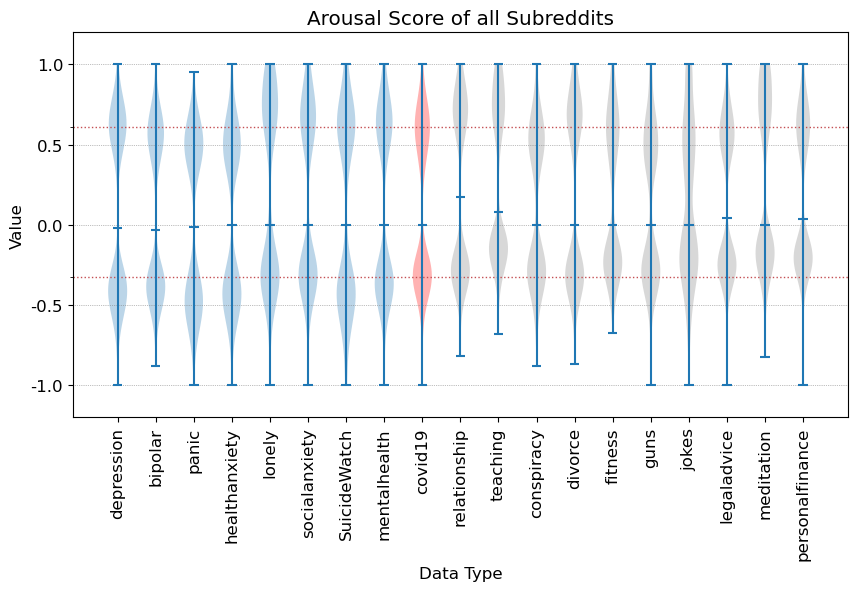

In [ ]:
va_violin_by_reddits(ALL_MID_COVID, names, 'avgPA', 'avgNA','Arousal Score of all Subreddits')

/var/folders/sl/qqf_xzvs6zddpqnd586m66p80000gn/T/ipykernel_1075/1517810122.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_df[negative_item] *= (-1)
/var/folders/sl/qqf_xzvs6zddpqnd586m66p80000gn/T/ipykernel_1075/1517810122.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_df[negative_item] *= (-1)


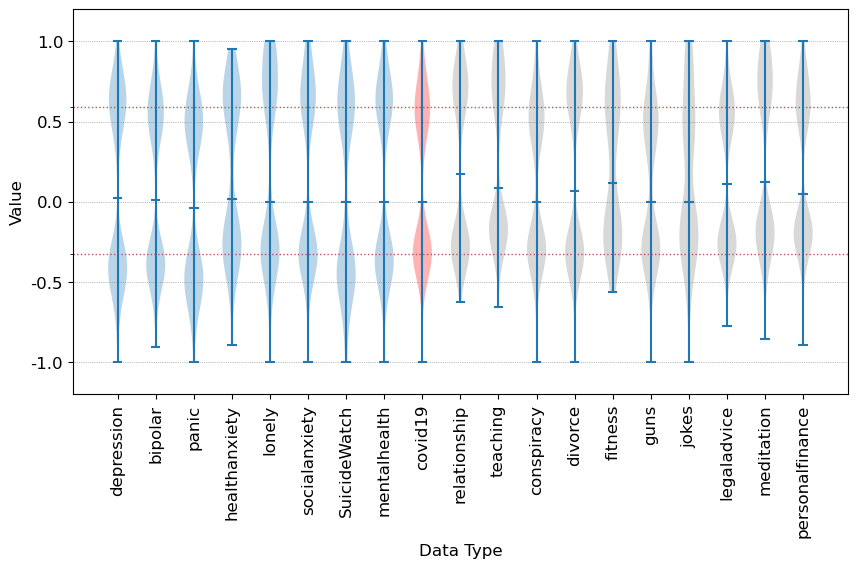

In [ ]:
va_violin_by_reddits(ALL_AFT_COVID, names, 'avgPA', 'avgNA')

# Covid 기간별 차이 분석


In [ ]:
ALL_DF = pd.read_csv("./sample_dataset/sample_scoring_result/scoring_result_all.csv")
ALL_DF.head()

all_df_bySub = []
for i in range(len(names)):
    temp = ALL_DF[ALL_DF['subreddit'] == names[i]]
    temp.reset_index(drop=True, inplace=True)
    all_df_bySub.append(temp)

print([len(a) for a in all_df_bySub])

In [ ]:
ALL_DF

date  year  month  hour  VATokenNum  CITokenNum  NVnum  \
0      2019-06-12 16:25:30  2019      6    16         176          36     18   
1      2019-06-19 02:03:04  2019      6     2         193          48     28   
2      2019-10-16 11:24:45  2019     10    11         498         103     63   
3      2019-06-24 20:23:44  2019      6    20         259          50     34   
4      2019-03-06 00:54:08  2019      3     0         179          40     25   
...                    ...   ...    ...   ...         ...         ...    ...   
54755  2022-02-24 20:21:12  2022      2    20         870         154     91   
54756  2022-02-18 17:39:39  2022      2    17         229          54     19   
54757  2022-01-05 18:59:15  2022      1    18         128          27      7   
54758  2022-01-22 11:35:52  2022      1    11          37           4      6   
54759  2022-01-09 22:54:06  2022      1    22          80          12      5   

       PVnum  NAnum  PAnum  ...  Topic 2  Topic 3   Topic 4   Topic 5  \
0         35     20     33  ...      0.0      0.0  0.000000  0.000000   
1         46     29     45  ...      0.0      0.0  0.000000  0.963459   
2        101     71     93  ...      0.0      0.0  0.000000  0.000000   
3         53     37     50  ...      0.0      0.0  0.027438  0.000000   
4         31     27     29  ...      0.0      0.0  0.000000  0.000000   
...      ...    ...    ...  ...      ...      ...       ...       ...   
54755    227    116    200  ...      0.0      0.0  0.000000  0.000000   
54756     67     32     53  ...      0.0      0.0  0.000000  0.375203   
54757     37     11     33  ...      0.0      0.0  0.573625  0.000000   
54758      7      6      7  ...      0.0      0.0  0.000000  0.000000   
54759     18      8     15  ...      0.0      0.0  0.533445  0.000000   

        Topic 6   Topic 7   Topic 8   Topic 9        subreddit         period  
0      0.980850  0.000000  0.000000  0.000000       depression   pre-pandemic  
1      0.021156  0.000000  0.000000  0.000000       depression   pre-pandemic  
2      0.989534  0.000000  0.000000  0.000000       depression   pre-pandemic  
3      0.010016  0.000000  0.000000  0.956240       depression   pre-pandemic  
4      0.012758  0.977014  0.000000  0.000000       depression   pre-pandemic  
...         ...       ...       ...       ...              ...            ...  
54755  0.556913  0.000000  0.354466  0.033522  personalfinance  post-pandemic  
54756  0.011829  0.000000  0.000000  0.000000  personalfinance  post-pandemic  
54757  0.011403  0.377635  0.000000  0.000000  personalfinance  post-pandemic  
54758  0.631367  0.000000  0.000000  0.000000  personalfinance  post-pandemic  
54759  0.016644  0.000000  0.347543  0.000000  personalfinance  post-pandemic  

[54760 rows x 34 columns]

In [91]:
# 구간 나누기 (topic 10개 데이터셋으로 최종 결과)
ALL_BEF_COVID = []
for i in range(19):
    # df = ALL_DF
    df = ALL_DF[ALL_DF['subreddit'] == names[i]] 
    df = df[df['period'] == 'pre-pandemic']
    ALL_BEF_COVID.append(df)

ALL_MID_COVID = []
for i in range(19):
    # df = ALL_DF
    df = ALL_DF[ALL_DF['subreddit'] == names[i]] 
    df = df[df['period'] == 'mid-pandemic']
    ALL_MID_COVID.append(df)

ALL_AFT_COVID = []
for i in range(19):
    # df = ALL_DF
    df = ALL_DF[ALL_DF['subreddit'] == names[i]] 
    df = df[df['period'] == 'post-pandemic']
    ALL_AFT_COVID.append(df)

In [ ]:
print([len(ALL_BEF_COVID[i])+len(ALL_MID_COVID[i])+len(ALL_AFT_COVID[i]) for i in range(19)])

In [ ]:
def heat_df_compare(datasets1, datasets2, names,title):

    heatmap_df1 = pd.DataFrame()
    indexes = [datasets1[0].columns[4:-2]]
    for i in range(len(names)):
        temp = datasets1[i]
        mean_df = temp[temp.columns[4:-2]].mean()
        heatmap_df1[names[i]] = mean_df
        

    heatmap_df1.index = indexes

    ## ordering
    heatmap_df1 = heatmap_df1[ENVIRONMENT + MENTAL + NONMENTAL]

    heatmap_df2 = pd.DataFrame()
    indexes = [datasets2[0].columns[4:-2]]
    for i in range(len(names)):
        temp = datasets2[i]
        mean_df = temp[temp.columns[4:-2]].mean()
        heatmap_df2[names[i]] = mean_df
        

    heatmap_df2.index = indexes

    ## ordering
    heatmap_df2 = heatmap_df2[ENVIRONMENT + MENTAL + NONMENTAL]

    heatmap_df3 = heatmap_df1 - heatmap_df2
    for row in range(len(heatmap_df3)):
        row_data = heatmap_df3.loc[heatmap_df3.index[row]]
        row_data = (row_data - row_data.mean()) / row_data.std()
        heatmap_df3.loc[heatmap_df3.index[row]] = row_data

    
    plt.figure(figsize = (20,10))
    sns.heatmap(heatmap_df3, annot=True, cmap='PRGn',linewidths=.5, vmin=-4.0, vmax=4.0)
    plt.title(title,fontdict = {'fontsize' : 40})
    plt.show()

    # return heatmap_df1


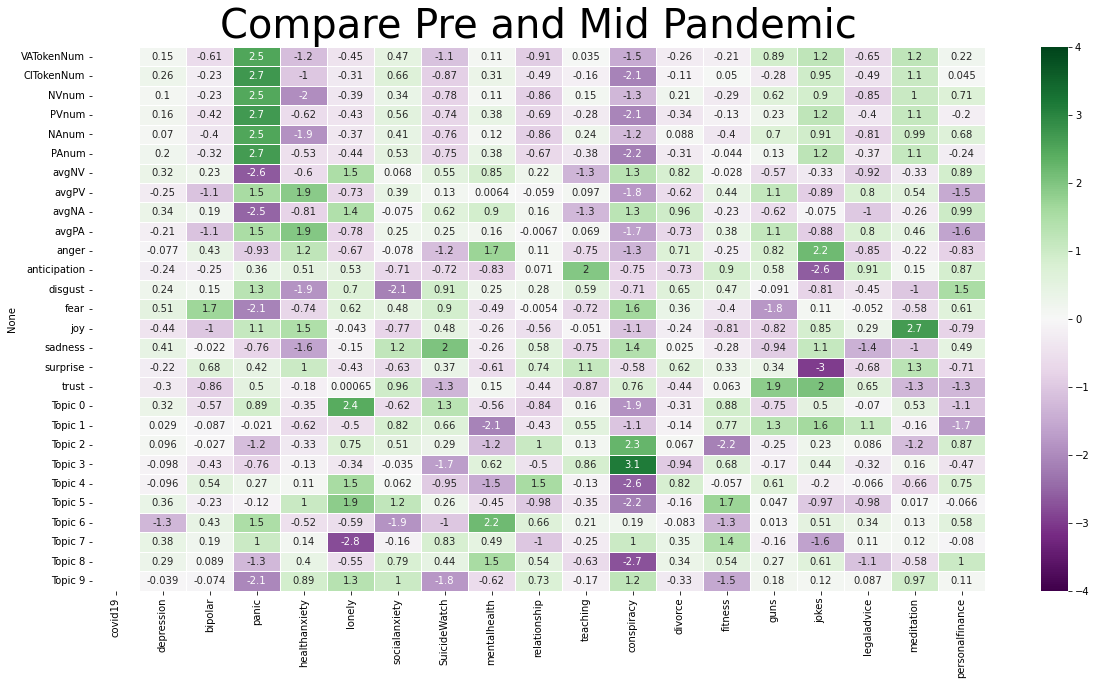

In [ ]:
temp = heat_df_compare(ALL_MID_COVID, ALL_BEF_COVID, names, 'Compare Pre and Mid Pandemic')

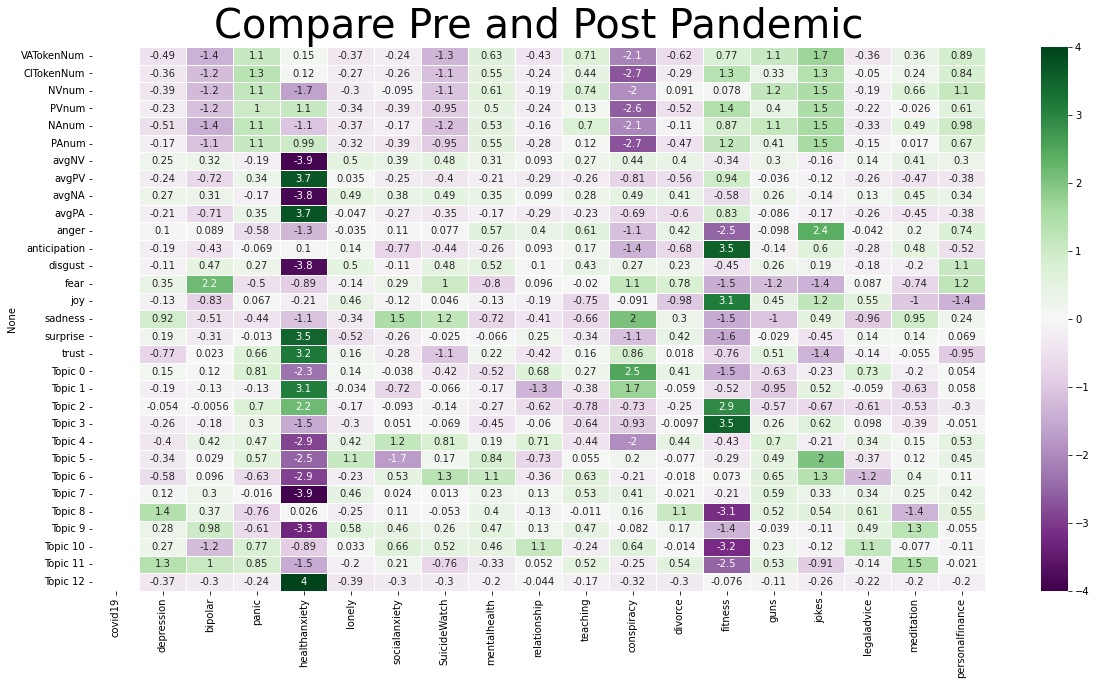

In [ ]:
temp = heat_df_compare(ALL_AFT_COVID, ALL_BEF_COVID, names,'Compare Pre and Post Pandemic')

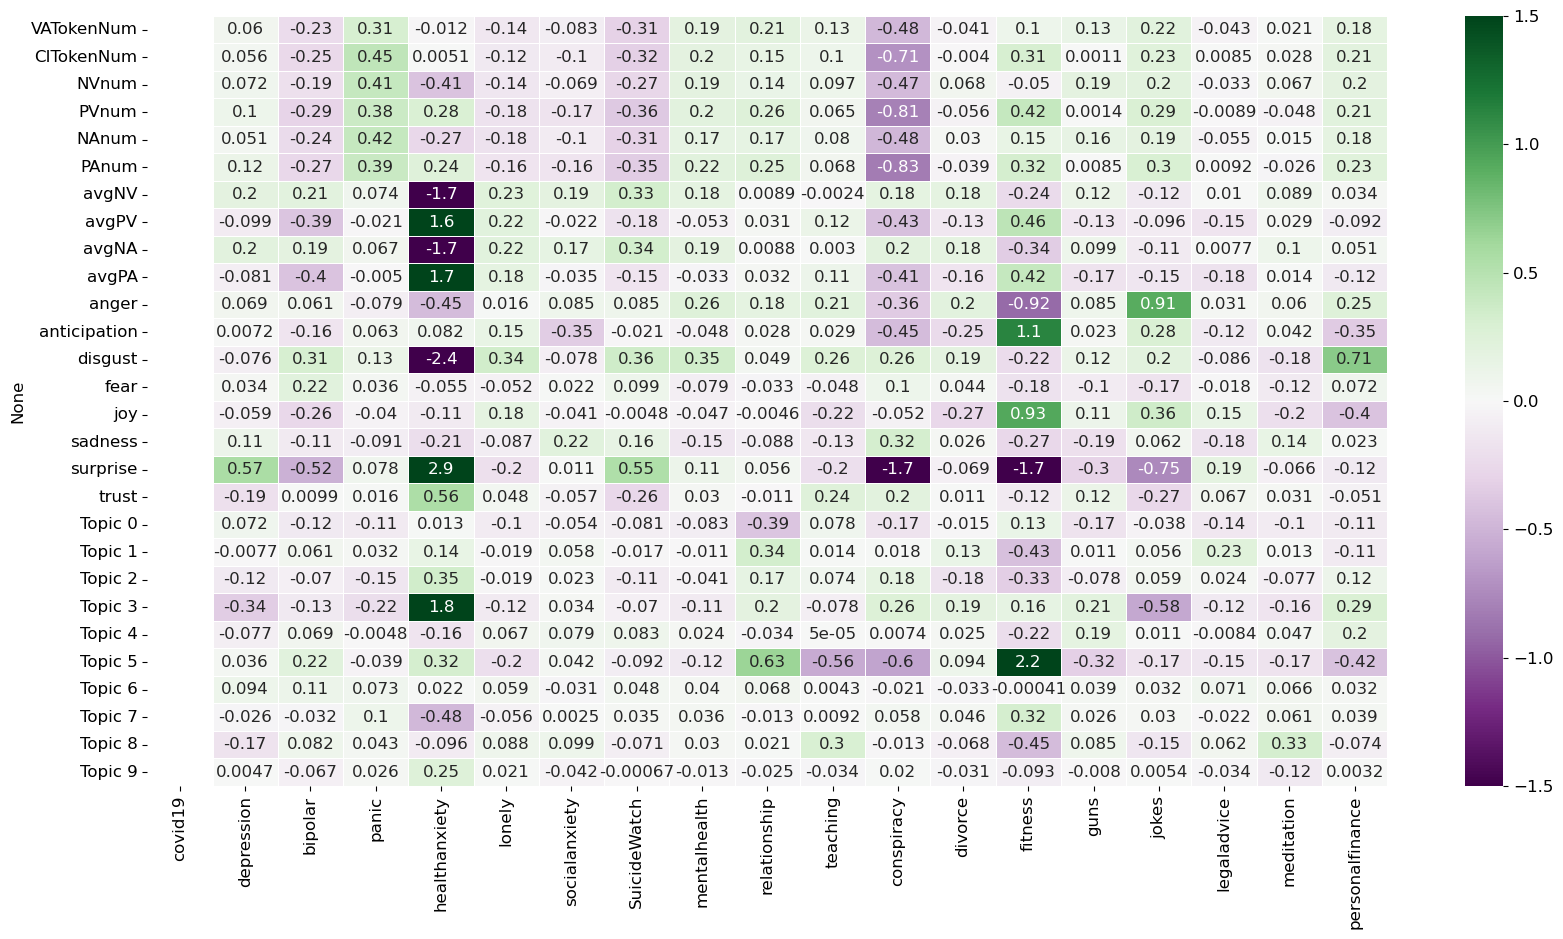

In [ ]:
temp = heat_df_compare(ALL_AFT_COVID, ALL_BEF_COVID, names)

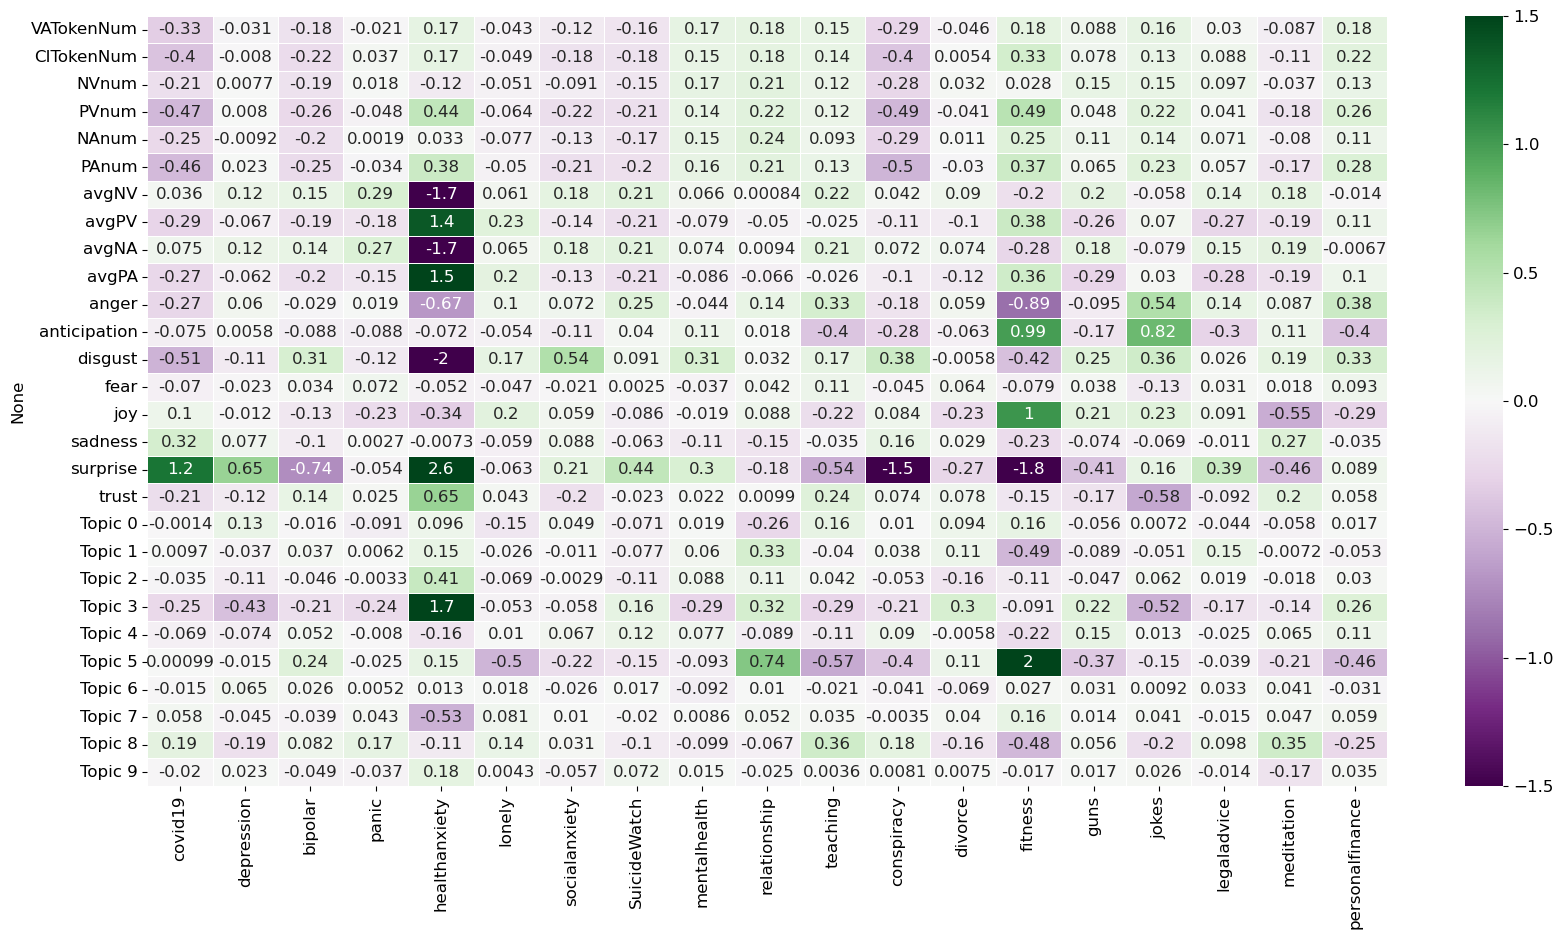

In [ ]:
temp = heat_df_compare(ALL_AFT_COVID, ALL_MID_COVID, names)

## 최종결과물 시각화 결과 수정

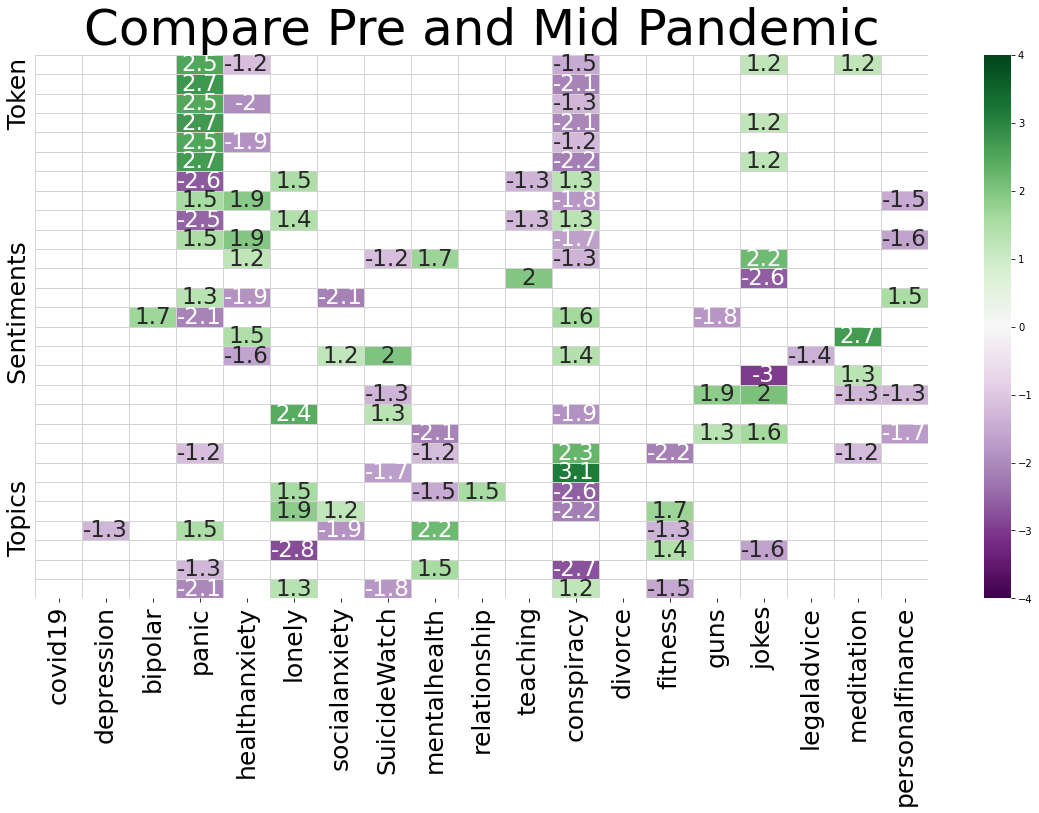

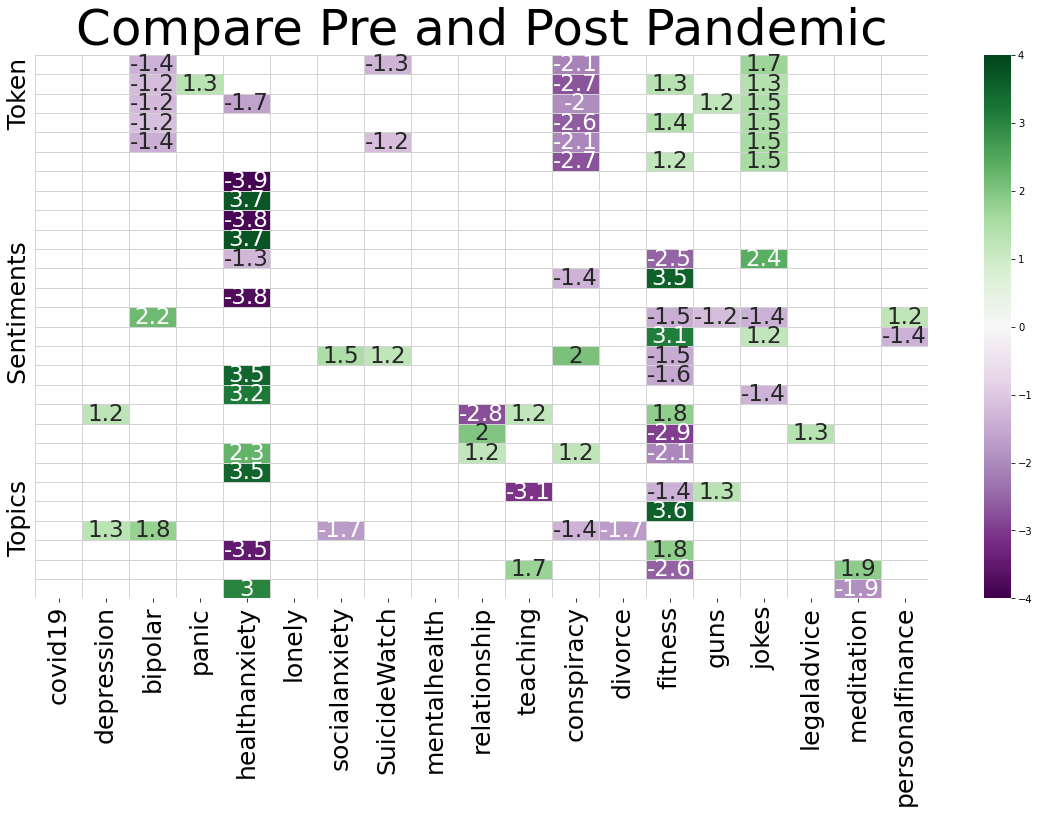

In [95]:
from cmath import nan


def heat_df_compare_(datasets1, datasets2, names,title):

    heatmap_df1 = pd.DataFrame()
    indexes = [datasets1[0].columns[4:-2]]
    for i in range(len(names)):
        temp = datasets1[i]
        mean_df = temp[temp.columns[4:-2]].mean()
        heatmap_df1[names[i]] = mean_df
        

    heatmap_df1.index = indexes

    ## ordering
    heatmap_df1 = heatmap_df1[ENVIRONMENT + MENTAL + NONMENTAL]

    heatmap_df2 = pd.DataFrame()
    indexes = [datasets2[0].columns[4:-2]]
    for i in range(len(names)):
        temp = datasets2[i]
        mean_df = temp[temp.columns[4:-2]].mean()
        heatmap_df2[names[i]] = mean_df
        

    heatmap_df2.index = indexes

    ## ordering
    heatmap_df2 = heatmap_df2[ENVIRONMENT + MENTAL + NONMENTAL]

    heatmap_df3 = heatmap_df1 - heatmap_df2
    for row in range(len(heatmap_df3)):
        row_data = heatmap_df3.loc[heatmap_df3.index[row]]
        row_data = (row_data - row_data.mean()) / row_data.std()
        heatmap_df3.loc[heatmap_df3.index[row]] = row_data

    
    for col in heatmap_df3.columns:
        if heatmap_df3[col].isnull().values.any():
            continue

        heatmap_df3[col] = np.where((heatmap_df3[col] <= 1.15) & (heatmap_df3[col]>= -1.15) , nan, heatmap_df3[col])

    plt.rc('xtick', labelsize=25) 
    plt.figure(figsize = (20,10)) 
    sns.heatmap(heatmap_df3, annot=True, cmap='PRGn',linewidths=.5, vmin=-4.0, vmax=4.0,annot_kws={"size": 23},linecolor='lightgray')
    
    ## y축 서식
    ax = plt.gca()
    ax.set_yticks([])
    ax.set_ylabel('      Topics            Sentiments              Token ',fontsize=25)
    plt.title(title,fontdict = {'fontsize' : 50})
    plt.show()   
    return heatmap_df3

temp = heat_df_compare_(ALL_MID_COVID, ALL_BEF_COVID, names, 'Compare Pre and Mid Pandemic')
temp = heat_df_compare_(ALL_AFT_COVID, ALL_BEF_COVID, names,'Compare Pre and Post Pandemic')